In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-161e6472-3e7e-7d90-c426-5a76a9ccc7b5)


# Load libraries and data

## Libraries & dependencies

In [2]:
%%capture
!pip uninstall torch -y
!pip install torch==2.0.1
!apt-get install libcairo2
!pip install --default-timeout=100 --upgrade xgboost lightgbm catboost torchviz shap basemap typing-extensions networkx igraph holoviews geoviews datashader scikit-image geoplot tensorflow searoute spectral cartopy spektral country_converter


In [3]:
from catboost import CatBoostRegressor
from copy import deepcopy
from tqdm import tqdm
from google.colab import drive
from importlib.machinery import SourceFileLoader
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau as ReduceLROnPlateau_KERAS
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import country_converter as coco
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import networkx as nx
from itertools import combinations
import numpy as np
import random
from scipy.stats import zscore
import os
import pandas as pd
import plotly.express as px
import tensorflow as tf
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
from torchviz import make_dot
from multiprocessing import Pool
import shap

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display
from IPython.display import HTML
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Lambda
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from math import atan2
from math import cos
from math import radians
from math import sin
from math import sqrt
from pathlib import Path
from scipy.interpolate import splev
import scipy.stats
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from spektral import transforms as T
from spektral.layers import GraphSageConv
from spektral.utils import normalized_adjacency
import gdown
import cartopy
import geoviews as gv
import igraph as ig
import multiprocessing as mp
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import searoute as sr
import contextily as ctx

In [4]:
torch.__version__

'2.0.1+cu117'

In [5]:
# Set seed to ensure reproducibility
seed = 42

# Seed Python's random module
random.seed(seed)

# Seed Numpy's random generator
np.random.seed(seed)

# Seed PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if multi GPUs available
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Dataset

In [6]:
ROOT = '/content/drive'
PROJECT = 'MyDrive/RiskNetwork/'
PATH = os.path.join(ROOT, PROJECT)
drive.mount(ROOT, force_remount=True)
cc = coco.CountryConverter()

Mounted at /content/drive


### Economic data

In [7]:
df_hs17 = pd.read_stata(PATH + 'data/trade/country_partner_hsproduct4digit_year_2017.dta')
df_hs18 = pd.read_stata(PATH + 'data/trade/country_partner_hsproduct4digit_year_2018.dta')
df_hs19 = pd.read_stata(PATH + 'data/trade/country_partner_hsproduct4digit_year_2019.dta')
df_product = pd.read_stata(PATH + 'data/trade/hs_product.dta')
df_loc = pd.read_stata(PATH + 'data/trade/location.dta')

### Port visits (fluxes data)

In [8]:
df_visit = pd.read_csv(PATH + 'data/visit-dataset/visits-augmented.csv')
df_port = pd.read_csv(PATH + 'data/world_port_index/UpdatedPub150.csv')
df_region = pd.read_csv(PATH + 'data/country_code.csv')

name_switch_ = {'Midway Islands': 'United States',
                'Johnson Atoll': 'United States',
                'Wake Island': 'United States'}

df_port.replace({'Country Code': name_switch_}, inplace=True)

df_port['country_code_iso3'] = cc.pandas_convert(series=df_port['Country Code'], to='ISO3')
df_port = df_port.merge(df_region[['alpha-3','sub-region']],
                        left_on='country_code_iso3',
                        right_on='alpha-3')
df_port = df_port.drop('alpha-3', axis=1)  # drop column
df_port = df_port.rename(columns={'Country Code': 'Country Name'})
df_port.loc[df_port['sub-region'].isna(), ['sub-region']] = 'Antarctica'

df_visit['start'] = pd.to_datetime(df_visit['start'])
df_visit['end'] = pd.to_datetime(df_visit['end'])

# Use 2017 & 2018 data for training purpose and leave 2019 for validation
df_visit17 = df_visit[df_visit['start'].dt.year == 2017]
df_visit18 = df_visit[df_visit['start'].dt.year == 2018]
df_visit19 = df_visit[df_visit['start'].dt.year == 2019]

### Sea-route distances

In [14]:
df_dist = pd.read_csv(PATH + 'data/sea_route_distances.csv')
df_dist = df_dist.merge(df_port[['World Port Index Number', 'Latitude', 'Longitude']], left_on='SourcePort',
                     right_on='World Port Index Number').drop(['World Port Index Number'], axis=1).rename(columns={'Latitude':'source_lat', 'Longitude':'source_lon'})
df_dist = df_dist.merge(df_port[['World Port Index Number', 'Latitude', 'Longitude']], left_on='TargetPort',
                     right_on='World Port Index Number').drop(['World Port Index Number'], axis=1).rename(columns={'Latitude':'target_lat', 'Longitude':'target_lon'})

In [15]:
# Create a dictionary to quickly look up distances
sea_distance_dict = {(row['SourcePort'], row['TargetPort']): row['Distance'] for _, row in df_dist.iterrows()}

Check the sea route distance calculation on a port pair:

19482.6 km


The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


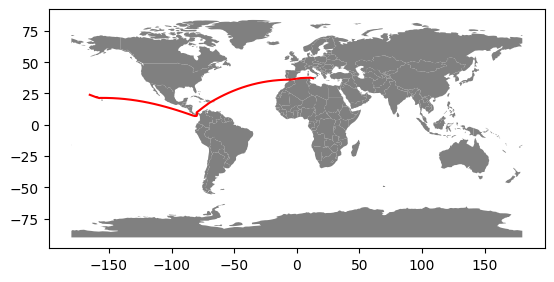

In [ ]:
origin = [-166.283333	, 23.866667] # [longitude, latitude]

destination = [13.528, 37.278] # [longitude, latitude]

route = sr.searoute(origin, destination)
# > Returns a GeoJSON LineString Feature
# show route distance with unit
print("{:.1f} {}".format(route.properties['length'], route.properties['units']))

# Create a GeoDataFrame from your GeoJSON object
gdf = gpd.GeoDataFrame.from_features([route])

# Plot the world map as background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = geoplot.polyplot(world, projection=gcrs.PlateCarree())

# Overlay the GeoDataFrame
# Plot the world
ax = world.plot(color='gray')

# Plot the GeoDataFrame
gdf.plot(color='red', ax=ax)

plt.show()

# Graph pipeline

## Graph analysis functions

In [12]:
def data2nx_graph(flow: pd.DataFrame, port: pd.DataFrame) -> nx.DiGraph:
    """
    Convert the flow dataframe to networkx graph, and incorporate features to the graph attributes.
    :param flow: data of real vessel flows
    :param port: world port index
    """
    # Group by source_port and target_port, then count the number of trips (NumberOfTrips)
    flow = flow.groupby(['source_port','target_port']).size().reset_index().rename(columns={0: "NumberOfTrips"})
    flow = flow.merge(port[['World Port Index Number','Latitude','Longitude']], left_on='source_port', right_on='World Port Index Number', how='left').drop('World Port Index Number',axis=1).rename(columns={'Latitude':'source_lat', 'Longitude':'source_lon'})
    flow = flow.merge(port[['World Port Index Number','Latitude','Longitude']], left_on='target_port', right_on='World Port Index Number', how='left').drop('World Port Index Number',axis=1).rename(columns={'Latitude':'target_lat', 'Longitude':'target_lon'})

    # Initialize a directed graph
    G = nx.DiGraph()

    G = nx.from_pandas_edgelist(flow, source='source_port', target='target_port',
                                edge_attr=['NumberOfTrips'], create_using=nx.DiGraph())

    # Add edges to the graph from DataFrame
    for _, row in flow.iterrows():
        G.nodes[row['source_port']]['latitude'] = row['source_lat']
        G.nodes[row['source_port']]['longitude'] = row['source_lon']
        G.nodes[row['target_port']]['latitude'] = row['target_lat']
        G.nodes[row['target_port']]['longitude'] = row['target_lon']

    return G


def memoized_haversine():
    R = 6371.0  # Radius of Earth in kilometers
    cache = {}  # Create a cache to save previously calculated distances

    def haversine(lat1, lon1, lat2, lon2):
        # Check if the distance between these points has been computed before
        if (lat1, lon1, lat2, lon2) in cache:
            return cache[(lat1, lon1, lat2, lon2)]  # Return the cached distance

        # Convert the latitude and longitude values from degrees to radians
        lat1_rad = radians(lat1)
        lon1_rad = radians(lon1)
        lat2_rad = radians(lat2)
        lon2_rad = radians(lon2)

        # Calculate the differences in the coordinates
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad

        # Haversine formula to calculate the distance between two points on a sphere
        a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        # Calculate the actual distance
        distance = R * c

        # Store the calculated distance in cache
        cache[(lat1, lon1, lat2, lon2)] = distance
        return distance

    return haversine  # Return the distance calculation function

# Initialize the memoized haversine function
haversine = memoized_haversine()


def compute_graph_metrics_nx(G: nx.DiGraph):
    """Compute graph metrics like betweenness, closeness, and pagerank."""
    with Pool() as pool:
        between = pool.apply_async(nx.betweenness_centrality, args=(G,), kwds={'weight': 'NumberOfTrips'})
        close = pool.apply_async(nx.closeness_centrality, args=(G,))
        pagerank = pool.apply_async(nx.pagerank, args=(G,), kwds={'weight': 'NumberOfTrips'})

        betweenness_dict = between.get()
        closeness_dict = close.get()
        pagerank_dict = pagerank.get()

    return betweenness_dict, closeness_dict, pagerank_dict


def fully_connect_graph(G):
    # Iterate over each node in the graph
    for node1 in tqdm(G.nodes(), desc="Connecting nodes"):
        for node2 in G.nodes():
            # Avoid creating self-loops
            if node1 != node2:
                # If the edge already exists in the graph
                if G.has_edge(node1, node2):
                    # Fetch latitude and longitude of both nodes
                    lat1, lon1 = G.nodes[node1]['latitude'], G.nodes[node1]['longitude']
                    lat2, lon2 = G.nodes[node2]['latitude'], G.nodes[node2]['longitude']
                    # Compute haversine distance between the two nodes and assign it as an attribute of the edge
                    dist = haversine(lat1, lon1, lat2, lon2)
                    G[node1][node2]['HaversineDistance'] = dist
                    # Add sea route distances
                    sea_dict = sea_distance_dict.get((node1, node2), sea_distance_dict.get((node2, node1), None))
                    G[node1][node2]['SeaRouteDistance'] = sea_dict
                else:
                    # If the edge does not exist, create it with 'NumberOfTrips' attribute set to 0.1
                    G.add_edge(node1, node2, NumberOfTrips=0.1)
                    lat1, lon1 = G.nodes[node1]['latitude'], G.nodes[node1]['longitude']
                    lat2, lon2 = G.nodes[node2]['latitude'], G.nodes[node2]['longitude']
                    # Haversine distance
                    dist = haversine(lat1, lon1, lat2, lon2)
                    G[node1][node2]['HaversineDistance'] = dist
                    # Add sea route distances
                    sea_dict = sea_distance_dict.get((node1, node2), sea_distance_dict.get((node2, node1), None))
                    G[node1][node2]['SeaRouteDistance'] = sea_dict
            else:
                # For self-loops, ensure edge exists with 'NumberOfTrips' set to 0 and 'HaversineDistance' set to 0
                if not G.has_edge(node1, node2):
                    G.add_edge(node1, node2, NumberOfTrips=0)
                G[node1][node2]['HaversineDistance'] = 0
                G[node1][node2]['SeaRouteDistance'] = 0

    # Return the fully connected graph
    return G



def compute_edge_importance(G: nx.DiGraph) -> nx.DiGraph:
    """
    Compute the importance of each edge in the graph based on the normalized distance and number of trips.

    :param G: a networkx graph
    """
    # Initialize the min and max distances and trips to the min and max values of the 'SeaRouteDistance' and 'NumberOfTrips' edge attributes, respectively
    min_distance = min(data['HaversineDistance'] for _, _, data in G.edges(data=True))
    max_distance = max(data['HaversineDistance'] for _, _, data in G.edges(data=True))

    min_trips = min(data['NumberOfTrips'] for _, _, data in G.edges(data=True))
    max_trips = max(data['NumberOfTrips'] for _, _, data in G.edges(data=True))

    # Initialize the min and max longitude and latitude to negative and positive infinity, respectively
    longitude_max = float('-inf')
    longitude_min = float('inf')

    latitude_max = float('-inf')
    latitude_min = float('inf')

    # Update the min and max longitude and latitude to the min and max values of the 'longitude' and 'latitude' node attributes, respectively
    for node in tqdm(G.nodes, desc='Preparing Nodes'):
        latitude = G.nodes[node]['latitude']
        longitude = G.nodes[node]['longitude']

        latitude_min = min(latitude_min, latitude)
        latitude_max = max(latitude_max, latitude)

        longitude_min = min(longitude_min, longitude)
        longitude_max = max(longitude_max, longitude)

    # Compute the normalized distance and trips for each edge, and use them to compute the edge importance
    for u, v, data in tqdm(G.edges(data=True), desc='Preparing Edges'):
        normalized_distance = (data['HaversineDistance'] - min_distance) / (max_distance - min_distance) if max_distance > min_distance else 0
        normalized_trips = (data['NumberOfTrips'] - min_trips) / (max_trips - min_trips) if max_trips > min_trips else 0
        edge_importance = normalized_trips / (normalized_distance + 1e-8)  # Edge importance is the ratio of normalized trips to normalized distance (plus a small value to avoid division by zero)
        # EdgeImportance varies from 0 to Infinity (the higher the better)
        G[u][v]['EdgeImportance'] = edge_importance  # Add the computed edge importance to the edge attributes

    return G


def nx_graph2data(G: nx.DiGraph) -> pd.DataFrame:
    """Convert the graph data into a DataFrame."""

    # Create a dataFrame and unpack the attributes dictionary into separate columns
    df = pd.DataFrame([(u, v, data['NumberOfTrips'], data['HaversineDistance'], data['SeaRouteDistance'], data['EdgeImportance']) for u, v, data in G.edges(data=True)],
                  columns=['SourcePort', 'TargetPort', 'NumberOfTrips', 'HaversineDistance', 'SeaRouteDistance', 'EdgeImportance'])

    return df


def nx_graph2data_no_full(G: nx.DiGraph) -> pd.DataFrame:
    """Convert the graph data into a DataFrame, the graph is not fully-connected"""
    # Create a dataFrame and unpack the attributes dictionary into separate columns
    df = pd.DataFrame([(u, v, data['NumberOfTrips']) for u, v, data in G.edges(data=True)],
                  columns=['SourcePort', 'TargetPort', 'NumberOfTrips'])

    return df

def graph_pipeline(flow: pd.DataFrame, port: pd.DataFrame):
    """Main pipeline function for graph creation and analysis."""
    g = data2nx_graph(flow, port)
    bc_dict, cc_dict, pr_dict = compute_graph_metrics_nx(g)
    h = fully_connect_graph(g)
    h = compute_edge_importance(h)

    return nx_graph2data(g), bc_dict, cc_dict, pr_dict


def graph_pipeline_no_full(flow: pd.DataFrame, port: pd.DataFrame):
    """Graph processing pipeline without fully-connected graph created"""
    g = data2nx_graph(flow, port)
    bc_dict, cc_dict, pr_dict = compute_graph_metrics_nx(g)

    return nx_graph2data_no_full(g), bc_dict, cc_dict, pr_dict


## Data preprocessing

In [10]:
util = SourceFileLoader('util', path=PATH + 'util.py').load_module()

In [ ]:
def preprocess_eco(eco_df, df_loc):
    # Group by location_id and partner_id, then sum the export_value
    df = eco_df.groupby(['location_id','partner_id'])['export_value'].sum().reset_index()

    # Convert location_id to integer type in df_loc
    df_loc1 = df_loc.astype({'location_id': int})

    # Merge df with df_loc1 to get location_code for each location_id
    df = df.merge(df_loc1[['location_id','location_code']], on='location_id')

    # Merge df with df_loc1 again to get partner_code for each partner_id
    df = df.merge(df_loc1[['location_id','location_code']], left_on='partner_id', right_on='location_id').drop('location_id_y', axis=1).rename(columns={'location_id_x':'location_id','location_code_x':'location_code','location_code_y':'partner_code'})

    return df


def sampling_dataset(df, fraction):
    # Sort the flow dataframe by the source ports
    df.sort_values(by=['SourcePort','TargetPort'], inplace=True)

    # Create a DataFrame of unique sources
    unique_source = df[['SourcePort']].drop_duplicates()

    # Randomly sample the fraction of the source ports
    sampled_source = unique_source.sample(frac=fraction, random_state=42)  # use random_state for reproducibility

    # Create a mask that's True for rows where 'source port' match the one in sampled source port
    mask = df[['SourcePort']].apply(tuple, axis=1).isin(sampled_source.apply(tuple, axis=1))

    # Select the rows that match the mask
    df_sampled = df[mask]

    return df_sampled

In [ ]:
# Prepare data for training and validation
exp_data = pd.concat([df_hs17, df_hs18], ignore_index=True)
visit_data = df_visit[(df_visit['start'].dt.year == 2017) | (df_visit['start'].dt.year == 2018)]
exp_data_val, visit_data_val = df_hs19, df_visit19  # validation year's trade and port visits data


In [ ]:
# Data pipeline:
#     visit2flow -> graph pipeline
#     process economic data
df_flow = util.visit_to_flow(visit_data)
flow, bc_dict, cc_dict, pr_dict = graph_pipeline(df_flow, df_port)
# flow, bc_dict, cc_dict, pr_dict = graph_pipeline_no_full(df_flow, df_port)  # Use this pipeline to skip fully connected graph and also please skip binary classification
df_exp = preprocess_eco(exp_data, df_loc)
df_exp = df_exp.set_index(['location_code', 'partner_code']).sort_index()

df_flow19 = util.visit_to_flow(visit_data_val)
flow19, bc_dict19, cc_dict19, pr_dict19 = graph_pipeline(df_flow19, df_port)
df_exp19 = preprocess_eco(exp_data_val, df_loc)
df_exp19 = df_exp19.set_index(['location_code', 'partner_code']).sort_index()

Preparing Edges: 100%|██████████| 4959529/4959529 [00:07<00:00, 688753.77it/s]


# Link prediction

Link prediction in the shipping network with machine learning models

## Balanced sampling

In [ ]:
def binary_classes(df_flow):
    # Add the new column "IsTrip"
    df_flow['IsTrip'] = df_flow['NumberOfTrips'].apply(lambda x: 1 if x >= 1 else 0)

    return df_flow


def balanced_sampling(df):
    # Split the dataset into majority and minority classes
    majority_class = df[df['IsTrip'] == 0]
    minority_class = df[df['IsTrip'] == 1]

    # Under-sample the majority class using resample
    # Make sure the number of samples equals the size of the minority class
    majority_class_under = resample(majority_class,
                                    replace=False, # sample without replacement
                                    n_samples=len(minority_class), # match the number of samples in minority class
                                    random_state=42) # reproducible results

    # Concatenate the balanced majority and minority classes
    balanced_df = pd.concat([majority_class_under, minority_class], axis=0)

    # Sort the balanced dataframe by source and target ports
    balanced_df.sort_values(by=['SourcePort','TargetPort'], inplace=True)

    return balanced_df

def binary_feature_scaling(feature_df):
    # Separate the feature columns and target column from the input DataFrame
    feature_list = ['HaversineDistance','SeaRouteDistance','EdgeImportance']
    feature_cols, target_col = feature_df.loc[:, feature_list], feature_df[['IsTrip']]  # to modify

    # Apply PowerTransformer to scale the feature columns
    power_scaler = PowerTransformer()
    scaled_feature_cols = pd.DataFrame(power_scaler.fit_transform(feature_cols), index=feature_cols.index, columns=feature_cols.columns)

    # Apply MinMaxScaler to scale the features into [0, 1]
    minmax_scaler = MinMaxScaler()
    minmax_scaled_feature_cols = pd.DataFrame(minmax_scaler.fit_transform(scaled_feature_cols), index=scaled_feature_cols.index, columns=scaled_feature_cols.columns)

    # Concatenate the scaled features and target column back into a single DataFrame
    scaled_features = pd.concat([feature_df[['SourcePort','TargetPort','NumberOfTrips']], minmax_scaled_feature_cols, target_col], axis=1)

    return scaled_features

In [ ]:
flow = binary_classes(flow)
flow = balanced_sampling(flow)
flow = binary_feature_scaling(flow)

flow19 = binary_classes(flow19)
flow19 = balanced_sampling(flow19)
flow19 = binary_feature_scaling(flow19)

## Binary classification

In [ ]:
def trajectory_classification(X, y, X_val, y_val):
    # Split data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Define the models and their respective hyperparameters
    models_and_params = {
        'LogisticRegression':{
            'model': LogisticRegression(n_jobs=-1),
            'params': {
                'penalty': ['l2']
            }
        },
        'KNeighbors': {
            'model': KNeighborsClassifier(n_jobs=-1),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10],
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'params': {
                'max_depth': [3, 5, 7],
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(n_jobs=-1),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10],
            }
        }
    }

    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    best_models = {}
    for model_name, model_info in models_and_params.items():
        print(f'Processing {model_name}... \n')
        clf = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring=scorers, refit='accuracy', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_models[model_name] = clf.best_estimator_

    # Create a list to store accuracies
    valid_accuracy = []
    # Fitting the trained models on the validation dataset
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        valid_accuracy.append(accuracy)

    # Fitting the trained models on the test dataset
    test_accuracy = []
    for model_name, model in best_models.items():
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)

        test_accuracy.append(accuracy)

    return valid_accuracy, test_accuracy, models_and_params, best_models

Two features

Processing LogisticRegression... 

Processing KNeighbors... 

Processing DecisionTree... 

Processing XGBoost... 

Processing RandomForest... 



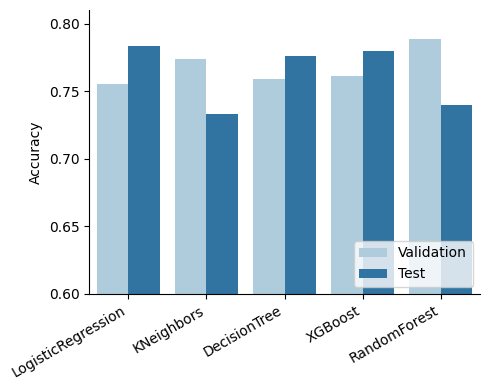

In [ ]:
# Split data into features (X) and target (y)
X, y = flow.loc[:, 'HaversineDistance':'SeaRouteDistance'], flow['IsTrip']
X_val, y_val = flow19[['HaversineDistance', 'SeaRouteDistance']], flow19['IsTrip']

valid_accuracy, test_accuracy, models_and_params, _ = trajectory_classification(X, y, X_val, y_val)

# prompt: Can I put the test_accuracy and the validation_accuray list into one dataframe and give models' names as the column names?
binary_results = pd.DataFrame(list(zip(models_and_params.keys(), valid_accuracy, test_accuracy)), columns=['Model', 'Validation', 'Test'])

fig, ax = plt.subplots(figsize=(5, 4))
df_result = binary_results.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=df_result, ax=ax, palette=sns.color_palette("Paired"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# Custom y-ticks
yticks = [0.60, 0.65, 0.70, 0.75, 0.80]
ax.set_yticks(yticks)
dic = {0.60: "0.60", 0.70: "0.70", 0.80: "0.80"}
labels = [yticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(yticks)]
ax.set_yticklabels(labels)

ax.set_ylim([0.6, 0.81])
ax.set(ylabel='Accuracy')
ax.legend(loc='lower right')

# Remove x-axis label
ax.set_xlabel('')

sns.despine(fig)
plt.tight_layout()
plt.savefig(PATH+'/images/link_pred_accuracy_NAedgeinfo.png', format='png', dpi=600)
plt.show()

Three features

Processing LogisticRegression... 

Processing KNeighbors... 

Processing DecisionTree... 

Processing XGBoost... 

Processing RandomForest... 



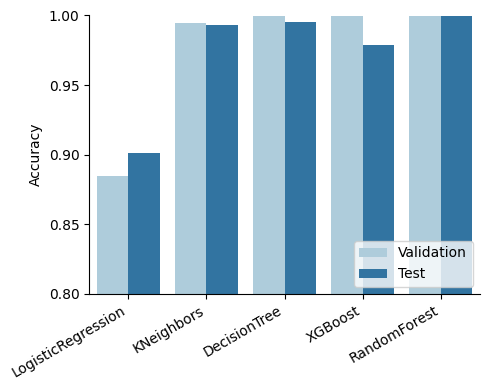

In [ ]:
# Split data into features (X) and target (y)
X, y = flow.loc[:, 'HaversineDistance':'EdgeImportance'], flow['IsTrip']
X_val, y_val = flow19[['HaversineDistance', 'SeaRouteDistance', 'EdgeImportance']], flow19['IsTrip']

valid_accuracy, test_accuracy, models_and_params, best_models = trajectory_classification(X, y, X_val, y_val)

# prompt: Can I put the test_accuracy and the validation_accuray list into one dataframe and give models' names as the column names?
binary_results = pd.DataFrame(list(zip(models_and_params.keys(), valid_accuracy, test_accuracy)), columns=['Model', 'Validation', 'Test'])

fig, ax = plt.subplots(figsize=(5, 4))
df_result = binary_results.melt(id_vars='Model').rename(columns=str.title)

sns.barplot(x='Model', y='Value', hue='Variable', data=df_result, ax=ax, palette=sns.color_palette("Paired"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# Custom y-ticks
yticks = [0.80, 0.85, 0.90, 0.95, 1.00]
ax.set_yticks(yticks)
dic = {0.80: "0.80", 0.90: "0.90", 1.0: "1.00"}
labels = [yticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(yticks)]
ax.set_yticklabels(labels)

ax.set_ylim([0.8, 1.0])
ax.set(ylabel='Accuracy')
# ax.set_yscale('log')
ax.legend(loc='lower right')

# Remove x-axis label
ax.set_xlabel('')

sns.despine(fig)
plt.tight_layout()
plt.savefig(PATH + '/images/link_pred_accuracy.png', format='png', dpi=600)
plt.show()

Make the trajectory filtering based on the 3-feature group with Logistic Regression model.

In [ ]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

model = best_models['LogisticRegression']
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     28890
           1       0.99      0.78      0.87     28802

    accuracy                           0.88     57692
   macro avg       0.90      0.88      0.88     57692
weighted avg       0.90      0.88      0.88     57692



In [ ]:
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90    115383
           1       0.99      0.78      0.87    115383

    accuracy                           0.89    230766
   macro avg       0.90      0.89      0.88    230766
weighted avg       0.90      0.89      0.88    230766



In [ ]:
# X_val, y_val = flow19[['HaversineDistance', 'SeaRouteDistance', 'EdgeImportance']], flow19['IsTrip']
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     79399
           1       0.99      0.81      0.89     79399

    accuracy                           0.90    158798
   macro avg       0.91      0.90      0.90    158798
weighted avg       0.91      0.90      0.90    158798



In [ ]:
# Combine predicted result into dataframe
sampled_flow = flow.copy()
sampled_flow.loc[:, 'IsTrip_pred'] = y_pred

# Fetch 2019 prediction results to dataframe
flow19.loc[:, 'IsTrip_pred'] = y_val_pred

# Mobility flow prediction

## Feature preparation

In [ ]:
# Adding features to flow set
port_location_mapping = df_port.set_index('World Port Index Number')[['Latitude', 'Longitude', 'sub-region', 'country_code_iso3']].to_dict(orient='index')

# Define a function to apply the map operation and handle NA values
def map_with_na_handling(port_id):
    if pd.isna(port_id):
        return {'Latitude': np.nan, 'Longitude': np.nan, 'sub-region': np.nan, 'country_code_iso3': np.nan}
    else:
        return port_location_mapping.get(port_id, {'Latitude': np.nan, 'Longitude': np.nan, 'sub-region': np.nan, 'country_code_iso3': np.nan})


def map_columns_and_merge(df, port_location_mapping):
    new_dfs = []
    df.dropna()
    for column in ['SourcePort', 'TargetPort']:
        new_df = pd.DataFrame(df[column].apply(map_with_na_handling).tolist(),
                              index=df.index)
        new_df.columns = [f'{col}_{column}' for col in new_df.columns]
        new_dfs.append(new_df)
    df = pd.concat([df] + new_dfs, axis=1)
    df.rename(columns={'country_code_iso3_SourcePort': 'SourceCountry',
                              'sub-region_SourcePort': 'SourceRegion',
                              'country_code_iso3_TargetPort': 'TargetCountry',
                              'sub-region_TargetPort': 'TargetRegion'}, inplace=True)

    return df

def incorporate_features(df, flux_port, flux_region, df_port, df_exp, bc_dict, cc_dict, pr_dict):
    """
    Incorporates various features into the DataFrame.

    :param df: Input DataFrame
    :param flux_port: DataFrame containing port-level fluxes
    :param flux_region: DataFrame containing regional fluxes
    :param df_port: DataFrame containing port data
    :param df_exp: DataFrame containing economic data
    :param bc_dict: Dictionary containing betweenness centrality data
    :param cc_dict: Dictionary containing closeness centrality data
    :param pr_dict: Dictionary containing page rank data
    :return: DataFrame with incorporated features
    """
    # Merge with exportation values
    export_value = pd.merge(df, df_exp, how='left',
                     left_on=['SourceCountry','TargetCountry'],
                     right_on=['location_code', 'partner_code'])
    export_value['export_value'].fillna(0.0, inplace=True)
    df['ExportValue'] = export_value['export_value']

    # A series of merge operations to gather relevant information
    df = df.merge(flux_port[['port', 'NumberOfStays']], left_on='SourcePort', right_on='port', how='left').drop('port', axis=1).rename(columns={'NumberOfStays': 'SourcePortFlux'})
    df = df.merge(flux_region[['sub-region', 'NumberOfStays']], left_on='TargetRegion', right_on='sub-region', how='left').drop('sub-region', axis=1).rename(columns={'NumberOfStays': 'TargetRegionFlux'})

    region_center = df_port.groupby('sub-region')[['Latitude','Longitude']].mean().reset_index()
    df = df.merge(region_center, left_on='TargetRegion', right_on='sub-region').drop('sub-region', axis=1).rename(columns={'Latitude':'Latitude_TargetRegion', 'Longitude':'Longitude_TargetRegion'})

    # Calculate distances
    df[['Latitude_SourcePort','Longitude_SourcePort']] = df[['Latitude_SourcePort','Longitude_SourcePort']].astype("float64")
    df['Distance'] = util.earth_distance(df['Latitude_SourcePort'], df['Longitude_SourcePort'], df['Latitude_TargetRegion'], df['Longitude_TargetRegion'])

    # Merge with graph features (betweenness centrality, closeness centrality and page rank) for source and target ports
    df = df.merge(pd.Series(bc_dict).rename('SourceBetweennessCentrality'), left_on=['SourcePort'], how='left', right_index=True).reset_index(drop=True)
    df = df.merge(pd.Series(bc_dict).rename('TargetBetweennessCentrality'), left_on=['TargetPort'], how='left', right_index=True).reset_index(drop=True)
    df = df.merge(pd.Series(cc_dict).rename('SourceClosenessCentrality'), left_on=['SourcePort'], how='left', right_index=True).reset_index(drop=True)
    df = df.merge(pd.Series(cc_dict).rename('TargetClosenessCentrality'), left_on=['TargetPort'], how='left', right_index=True).reset_index(drop=True)
    df = df.merge(pd.Series(pr_dict).rename('SourcePageRank'), left_on=['SourcePort'], how='left', right_index=True).reset_index(drop=True)
    df = df.merge(pd.Series(pr_dict).rename('TargetPageRank'), left_on=['TargetPort'], how='left', right_index=True).reset_index(drop=True)

    # ---------------- Keep same code at this line above ----------------
    region_stat = df.groupby('TargetRegion').agg(
        median_betweenness=('TargetBetweennessCentrality', 'median'),
        median_closeness=('TargetClosenessCentrality', 'median'),
        median_pagerank=('TargetPageRank', 'median')
    ).reset_index()

    # Group by certain columns and aggregate
    compute_dict = {'NumberOfTrips': 'sum', 'SourcePortFlux': 'mean', 'TargetRegionFlux': 'mean',
                'Distance': 'mean', 'ExportValue': 'sum',
                'SourceBetweennessCentrality': 'mean',
                'SourceClosenessCentrality': 'mean',
                'SourcePageRank': 'mean'}

    df = df.groupby(['SourcePort', 'TargetRegion']).agg(compute_dict).reset_index().sort_values(by=['SourcePort'], ignore_index=True).rename(columns={'NumberOfTrips': 'flow_size'})

    # Merge with regional median graph metrics for destination regions
    df = df.merge(region_stat, left_on='TargetRegion', right_on='TargetRegion', how='left').rename(columns={'median_betweenness':'TargetBetweennessCentrality','median_closeness':'TargetClosenessCentrality','median_pagerank':'TargetPageRank'})

    # Calculate outflow and flow ratio
    outflow = df.groupby(['SourcePort'])['flow_size'].sum().reset_index().rename(columns={"flow_size": "outflow"})
    df = df.merge(outflow[['SourcePort', 'outflow']], on=['SourcePort'])
    df['flow_ratio'] = df['flow_size'] / df['outflow']

    return df

In [ ]:
# Group port visits by port, latitude, and longitude, and count the number of stays
flux_port = visit_data.groupby(['port', 'latitude', 'longitude']).size().reset_index().rename({0: 'NumberOfStays'}, axis=1)
flux_port = flux_port.merge(df_port[['World Port Index Number', 'sub-region']], left_on='port', right_on='World Port Index Number').drop('World Port Index Number', axis=1)
flux_port19 = visit_data_val.groupby(['port', 'latitude', 'longitude']).size().reset_index().rename({0: 'NumberOfStays'}, axis=1)
flux_port19 = flux_port19.merge(df_port[['World Port Index Number', 'sub-region']], left_on='port', right_on='World Port Index Number').drop('World Port Index Number', axis=1)

# Group port visits by sub-region and sum the number of stays
flux_region = flux_port.groupby('sub-region')['NumberOfStays'].sum().reset_index()
flux_region19 = flux_port19.groupby('sub-region')['NumberOfStays'].sum().reset_index()

In [ ]:
# Keep a copy of the port pairs that no flows predicted for robustness test later
sampled_flow_false = sampled_flow[sampled_flow['IsTrip_pred'] == 0]
sampled_flow_false = sampled_flow_false.merge(flow19[['SourcePort','TargetPort','IsTrip']], on=['SourcePort','TargetPort'], how='left', suffixes=('', '_val')).fillna(0)

In [ ]:
# Drop the port pairs that been predicted no flows occurred
sampled_flow = sampled_flow[sampled_flow['IsTrip_pred'] != 0].drop(columns=['HaversineDistance','SeaRouteDistance','IsTrip','IsTrip_pred']).reset_index(drop=True)
flow19 = flow19[flow19['IsTrip_pred'] != 0].reset_index(drop=True)

In [ ]:
# Match with ports' information
df_flow = map_columns_and_merge(sampled_flow, port_location_mapping)
df_flow19 = map_columns_and_merge(flow19, port_location_mapping)

In [ ]:
# Validate result for pred 0 trip
df_flow_false = map_columns_and_merge(sampled_flow_false, port_location_mapping)

In [ ]:
# Incorporate with features
df_flow = incorporate_features(df_flow, flux_port, flux_region, df_port, df_exp, bc_dict, cc_dict, pr_dict)

# Prepare test features
df_flow19 = incorporate_features(df_flow19, flux_port19, flux_region19, df_port, df_exp19, bc_dict19, cc_dict19, pr_dict19)

## Feature scaling

Scale feature columns and group source-destination pairs into data samples.

In [ ]:
def feature_scaling(feature_df):
    # Separate the feature columns and target column from the input DataFrame
    feature_cols, target_col = feature_df.loc[:, 'SourcePortFlux':'TargetPageRank'], feature_df[['flow_ratio']]

    # Apply PowerTransformer to scale the feature columns
    power_scaler = PowerTransformer()
    scaled_feature_cols = pd.DataFrame(power_scaler.fit_transform(feature_cols), index=feature_cols.index, columns=feature_cols.columns)

    # Apply MinMaxScaler to scale the features into [0, 1]
    minmax_scaler = MinMaxScaler()
    minmax_scaled_feature_cols = pd.DataFrame(minmax_scaler.fit_transform(scaled_feature_cols), index=scaled_feature_cols.index, columns=scaled_feature_cols.columns)

    # Concatenate the scaled features and target column back into a single DataFrame
    scaled_features = pd.concat([feature_df[['SourcePort']], minmax_scaled_feature_cols, target_col], axis=1)

    return scaled_features

In [ ]:
def feature_data_grouped(feature_df):
    # Convert the input DataFrame to a numpy array
    data = feature_df.to_numpy()

    # Initialize empty lists for group_data, group_target and validation
    group_val = []
    group_target = []
    group_data = []
    group_d = []
    group_t = []
    pid = None

    # Iterate through the rows of the data array
    for idx, row in enumerate(data):
        if idx == 0:
            pid = row[0]
        elif row[0] != pid:
            pid = row[0]
            group_data.append(group_d)
            group_target.append(group_t)
            group_d = []
            group_t = []

        # Append the feature values to group_d and target value to group_t
        # group_d.append([row[1], row[2], row[3], row[4], row[5], row[6], row[7]])
        group_d.append([row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10]])
        group_t.append(row[-1])

    # Append the last group_d and group_t to group_data and group_target
    group_data.append(group_d)
    group_target.append(group_t)

    return group_data, group_target

In [ ]:
# Feature scaling
scaled_features_w_port = feature_scaling(df_flow)
# Data separation
data_X, data_Y= feature_data_grouped(scaled_features_w_port)

# Feature scaling
scaled_features_w_port19 = feature_scaling(df_flow19)
# Data separation
test_X, test_Y= feature_data_grouped(scaled_features_w_port19)

In [ ]:
print(len(data_X), len(test_X))

2247 2211


## Baseline Models (machine learning regression models)

In [ ]:
from scipy.spatial.distance import jensenshannon
# Prepare the dataset for baseline models
X = np.vstack(data_X)
Y = np.hstack(data_Y)

# Initialize the baseline models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "Light GBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(silent=True)
}

# Define evaluation metrics along with CPC
# NRMSE
def nrmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_val = np.max(y_true)
    min_val = np.min(y_true)
    return np.sqrt(mse) / (max_val - min_val)

# Pearson Correlation Coefficient
def pearson_corr(y_true, y_pred):
    # return np.corrcoef(y_true, y_pred)[0, 1]
    corr, _ = scipy.stats.pearsonr(y_true, y_pred)
    return corr

# Jensen-Shannon Divergence
def js_divergence(y_true, y_pred):
    return jensenshannon(y_true, y_pred)

# Create custom scorers
cpc_scorer = make_scorer(util.common_part_of_commuters)
nrmse_scorer = make_scorer(nrmse, greater_is_better=False)
js_divergence_scorer = make_scorer(js_divergence, greater_is_better=False)
pearson_corr_scorer = make_scorer(pearson_corr, greater_is_better=True)

# scoring_metrics = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', cpc_scorer]
scoring_metrics = {
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'cpc_scorer': cpc_scorer,
    'nrmse_scorer': nrmse_scorer,
    'js_divergence_scorer': js_divergence_scorer,
    'pearson_corr_scorer': pearson_corr_scorer
}

# Evaluate each model
def evaluate_models(models, X, Y, cv=5, scoring_metrics=scoring_metrics):
    model_results = {}
    for name, model in models.items():
        scores = cross_validate(model, X, Y, cv=cv, scoring=scoring_metrics)
        model_results[name] = {
            'r2': scores['test_r2'].mean(),
            'mae': -scores['test_neg_mean_absolute_error'].mean(),
            'rmse': -scores['test_neg_root_mean_squared_error'].mean(),
            'nrmse': -scores['test_nrmse_scorer'].mean(),
            'jsd': -scores['test_js_divergence_scorer'].mean(),
            'pearson': scores['test_pearson_corr_scorer'].mean(),
            'cpc': scores['test_cpc_scorer'].mean(),
            'cpc_max': max(scores['test_cpc_scorer']),
            'cpc_min': min(scores['test_cpc_scorer'])
        }
    return model_results

cv_results = evaluate_models(models, X, Y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 6838, number of used features: 10
[LightGBM] [Info] Start training from score 0.249196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 6838, number of used features: 10
[LightGBM] [Info] Start training from score 0.245834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 6838, number of used features: 10
[LightGBM] [Info] Start traini

In [ ]:
tX = np.vstack(test_X)
tY = np.hstack(test_Y)

def fit_and_evaluate(train_X, train_Y, test_X, test_Y):
    model_test_result = {}

    for name, model in models.items():
        # Fit the model on the training data
        model.fit(train_X, train_Y)
        # Predict on the test data
        predictions = model.predict(test_X)
        # Calculate each metric
        test_nrmse = nrmse(test_Y, predictions)
        test_pearson = pearson_corr(test_Y, predictions)
        test_jsd = js_divergence(test_Y, predictions)
        test_cpc = util.common_part_of_commuters(test_Y, predictions)
    # Return a dictionary of all test metrics
        model_test_result[name] = {
            'NRMSE': test_nrmse,
            'Pearson': test_pearson,
            'JSD': test_jsd,
            'CPC': test_cpc
        }

    return model_test_result

# Example of using the function with a specific model, e.g., Random Forest
test_results = fit_and_evaluate(X, Y, tX, tY)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 8548, number of used features: 10
[LightGBM] [Info] Start training from score 0.262869


In [ ]:
print(f"Cross-validation results: {cv_results}")
print(f"Test results: {test_results}")

Cross-validation results: {'Linear Regression': {'r2': 0.19295681463235248, 'mae': 0.2636596631361286, 'rmse': 0.3273339780068334, 'nrmse': 0.32736955075194735, 'jsd': inf, 'pearson': 0.4571878037441732, 'cpc': 0.4744213714764906, 'cpc_max': 0.5639701759997833, 'cpc_min': 0.3532948979278747}, 'Decision Tree': {'r2': -0.19217412799421302, 'mae': 0.2298731720734477, 'rmse': 0.3960027425949695, 'nrmse': 0.39604591134021533, 'jsd': 0.48553282775827444, 'pearson': 0.39387416063062874, 'cpc': 0.5309576885803069, 'cpc_max': 0.6629223305707653, 'cpc_min': 0.45133058858628544}, 'Random Forest': {'r2': 0.2797617051306934, 'mae': 0.20913526144779682, 'rmse': 0.307736337123584, 'nrmse': 0.3077697785847823, 'jsd': 0.4015758893360689, 'pearson': 0.5502601134699855, 'cpc': 0.5784014525633606, 'cpc_max': 0.6891984205318823, 'cpc_min': 0.508302396416958}, 'Extra Trees': {'r2': 0.264129766372299, 'mae': 0.20987373976248228, 'rmse': 0.3108194228260897, 'nrmse': 0.31085318178386145, 'jsd': 0.4047954998334

## Gravity-Based Models

### Data loader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Data loader class for loading vessel movement data
class VesselFlowData(torch.utils.data.Dataset):
    def __init__(self, X: list[list], Y: list[list]) -> None:
        super().__init__()
        self.data_x = X  # Feature data (e.g., population of i and j, distance between i and j)
        self.data_y = Y  # Target data (e.g., real flow)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, index: int):
        x = torch.Tensor(self.data_x[index])
        y = torch.Tensor(self.data_y[index])

        return x, y

### Training and validation setup

In [ ]:
# Training function with detailed comments on inner workings
def train(epoch, optimizer, model, train_loader):
    model.train()
    running_loss = 0.0
    training_accuracy = 0.0

    for batch_idx, (data_x, data_y) in enumerate(train_loader):
        data_x = data_x.to(device)
        data_y = data_y.to(device)

        optimizer.zero_grad()
        # Calculate loss and CPC for each data-target pair in the batch
        loss = sum(model.loss(model(data), target) for data, target in zip(data_x, data_y))
        cpc_sum = sum(model.get_cpc(data, target) for data, target in zip(data_x, data_y))
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        running_loss += loss.item()
        training_accuracy += cpc_sum

    running_loss /= len(train_loader)
    training_accuracy /= len(train_loader)

    # print(f'Epoch {epoch}')
    # print(f'Running loss:  {running_loss} ---------- training accuracy: {training_accuracy}')
    return running_loss, training_accuracy


# Validation function with detailed comments on inner workings
def validate(model, valid_loader):
    model.eval()
    n_origins = 0
    val_loss = 0
    val_accuracy = 0

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for batch_idx, (data_x, data_y) in enumerate(valid_loader):
            data_x = data_x.to(device)
            data_y = data_y.to(device)

            # Calculate loss and CPC for each data-target pair in the batch
            loss = sum(model.loss(model(data), target).item() for data, target in zip(data_x, data_y))
            cpc_sum = sum(model.get_cpc(data, target) for data, target in zip(data_x, data_y))

            for data, target in zip(data_x, data_y):
                y_true = target.cpu().numpy().tolist()
                y_pred = model.get_pred(data, target).tolist()
                y_true_all.extend(y_true)
                y_pred_all.extend(y_pred)

            n_origins += 1
            val_loss += loss
            val_accuracy += cpc_sum

        val_loss /= n_origins
        val_accuracy /= n_origins

        # Convert lists to numpy arrays
        y_true_all = np.asarray(y_true_all, dtype=np.float32)
        y_pred_all = np.asarray(y_pred_all, dtype=np.float32)

        # Find where either array contains NaN or Inf
        invalid_indices = np.isnan(y_true_all) | np.isinf(y_true_all) | np.isnan(y_pred_all) | np.isinf(y_pred_all)

        # Filter out those indices
        filtered_y_true_all = y_true_all[~invalid_indices]
        filtered_y_pred_all = y_pred_all[~invalid_indices]

        if filtered_y_pred_all.size > 1:
            # Calculate NRMSE and correlation
            val_nrmse = nrmse(filtered_y_true_all, filtered_y_pred_all)
            val_corr = pearson_corr(filtered_y_true_all, filtered_y_pred_all)
            val_jsd = js_divergence(filtered_y_true_all, filtered_y_pred_all)
        else:
            val_nrmse = np.nan
            val_corr = np.nan
            val_jsd = np.nan

        # print(f'Validate loss: {val_loss} ---------- validate accuracy: {val_accuracy} \n')
        return val_loss, val_accuracy, val_nrmse, val_corr, val_jsd

In [ ]:
# Function to execute training and validation with early stopping and learning rate decay
def execute(epoch, trainloader, validloader, model, optimizer):
    train_acc_set, val_acc_set, train_loss_set, val_loss_set, nrmse_set, corr_set, jsd_set = ([] for _ in range(7))

    # Initialize learning rate scheduler for ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True, min_lr=0)

    # Initialize variables for early stopping
    best_val_acc = 0
    best_model_state = None
    no_improvement_count = 0

    for ep in range(1, epoch+1):
        train_loss, train_acc = train(epoch=ep, optimizer=optimizer, model=model, train_loader=trainloader)
        val_loss, val_acc, val_nrmse, val_corr, val_jsd = validate(model=model, valid_loader=validloader)

        print(f'Epoch {ep}')
        print(f'Running loss:  {train_loss} ---------- training accuracy: {train_acc}')
        print(f'Validate loss: {val_loss} ---------- validate accuracy: {val_acc} \n')

        # Update learning rate based on validating accuracy
        scheduler.step(val_acc)

        train_loss_set.append(train_loss)
        train_acc_set.append(train_acc)
        val_loss_set.append(val_loss)
        val_acc_set.append(val_acc)
        nrmse_set.append(val_nrmse)
        corr_set.append(val_corr)
        jsd_set.append(val_jsd)

        # Check for improvement in the validating accuracy and update the best model state accordingly
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Early stopping if there is no improvement after a certain number of epochs
        if no_improvement_count >= 20:
            print("Early stopping triggered.")
            break

    # Load the best model state before returning the results
    model.load_state_dict(best_model_state)

    return train_acc_set, val_acc_set, train_loss_set, val_loss_set, nrmse_set, corr_set, jsd_set

In [ ]:
# Function to reset weights of the model
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

### Visualization function

In [ ]:
from math import nan

def nan_padding(list_of_lists, padding_value=nan):
    max_length = max(len(lst) for lst in list_of_lists)
    return [(lst + [padding_value] * (max_length - len(lst))) for lst in list_of_lists]

In [ ]:
def plot_accuracy_and_loss(ax0, ax1, ax2, ax3, train_acc, val_acc, train_loss, val_loss, filename):
    train_acc = nan_padding(train_acc)
    val_acc = nan_padding(val_acc)
    train_loss = nan_padding(train_loss)
    val_loss = nan_padding(val_loss)
    mean_train_acc = np.nanmean(train_acc, axis=0)
    mean_val_acc = np.nanmean(val_acc, axis=0)
    mean_train_loss = np.nanmean(train_loss, axis=0)
    mean_val_loss = np.nanmean(val_loss, axis=0)

    for idx in range(len(train_acc)):
        ax0.plot(range(1, 1+len(train_acc[idx])), train_acc[idx], color='lightgrey')
        ax1.plot(range(1, 1+len(val_acc[idx])), val_acc[idx], color='lightgrey')
    ax0.plot(range(1, 1+len(mean_train_acc)), mean_train_acc, color='blue')
    ax1.plot(range(1, 1+len(mean_val_acc)), mean_val_acc, color='red')

    ax0.set(title="Train accuracy over 5 folds", xlabel='Epoch', ylabel='Accuracy')
    ax1.set(title="Validation accuracy over 5 folds", xlabel='Epoch', ylabel='Accuracy')
    ax0.get_shared_y_axes().join(ax0, ax1)

    for idx in range(len(train_loss)):
        ax2.plot(range(1, 1+len(train_loss[idx])), train_loss[idx], color='lightgrey')
        ax3.plot(range(1, 1+len(val_loss[idx])), val_loss[idx], color='lightgrey')

    ax2.plot(range(1, 1+len(mean_train_loss)), mean_train_loss, color='blue')
    ax3.plot(range(1, 1+len(mean_val_loss)), mean_val_loss, color='red')

    ax2.set(title="Train loss over 5 folds", xlabel='Epoch', ylabel='Loss')
    ax3.set(title="Validation loss over 5 folds", xlabel='Epoch', ylabel='Loss')
    ax2.get_shared_y_axes().join(ax2, ax3)

    plt.savefig(PATH+'./images/'+filename)

### Shallow gravity

In [ ]:
# Shallow Gravity model class
class ShallowGravity(torch.nn.Module):
    def __init__(self, dim_input):
        super().__init__()
        self.linear1 = torch.nn.Linear(dim_input, 1)  # Single linear layer for shallow network

    def forward(self, x):
        return self.linear1(x)  # Forward pass through the linear layer

    # Calculate entropy loss using log softmax and target values
    def loss(self, out, target):
        lsm = F.log_softmax(out.squeeze(), dim=-1)  # Apply log softmax to squeeze output tensor
        entropy_loss = -(target * lsm).sum()  # Calculate entropy loss by multiplying target with log softmax output and summing the result
        return entropy_loss

    # Convert predicted contents to probabilities using softmax function
    def predict_proba(self, x):
        probs = F.softmax(self.forward(x).squeeze(), dim=-1)  # Apply softmax to squeeze output tensor and calculate probabilities
        return probs.cpu().detach().numpy()

    # Calculate average OD model based on predicted probabilities and total outflow
    def average_OD_model(self, tX, tT):
        p = self.predict_proba(tX)  # Get predicted probabilities for input features
        tot_out_trips = tT.sum(dim=-1).cpu().detach().numpy()  # Calculate the sum of total outflow trips  # For a single data sample, the sum up value should be always 1.0
        model_od = (p.T * tot_out_trips).T  # Multiply predicted probabilities with total outflow trips to get the average OD model
        return model_od

    def get_pred(self, x, y_true):
        model_OD_test = self.average_OD_model(x.cuda(), y_true.cuda())  # Get the average OD model for input features and true values
        flatten_predicted = model_OD_test.flatten()  # Flatten predicted values into a 1D array
        return flatten_predicted

    # Get common part of commuters (CPC) by comparing observed and predicted values
    def get_cpc(self, x, y_true):
        flatten_observed = y_true.cpu().detach().numpy().flatten()  # Flatten observed values into a 1D array
        model_OD_test = self.average_OD_model(x.cuda(), y_true.cuda())  # Get the average OD model for input features and true values
        # model_OD_test = self.average_OD_model(x, y_true)  # Get the average OD model for input features and true values
        flatten_predicted = model_OD_test.flatten()
        cpc_test = util.common_part_of_commuters(flatten_observed, flatten_predicted)  # Calculate CPC using observed and predicted values
        return cpc_test

Reset trainable parameters of layer = Linear(in_features=10, out_features=1, bias=True)
Start training and testing on fold 1 ... 

Epoch 1
Running loss:  0.946638974701622 ---------- training accuracy: 0.6366594522513929
Validate loss: 0.9441436820891168 ---------- validate accuracy: 0.6457425795324405 

Epoch 2
Running loss:  0.9268421673433079 ---------- training accuracy: 0.646308418260612
Validate loss: 0.9390343589418464 ---------- validate accuracy: 0.6499677450969046 

Epoch 3
Running loss:  0.9261899211578192 ---------- training accuracy: 0.6489853699137487
Validate loss: 0.9389673831396633 ---------- validate accuracy: 0.6500975020093379 

Epoch 4
Running loss:  0.9259591525753272 ---------- training accuracy: 0.6476203852043078
Validate loss: 0.9404820855458578 ---------- validate accuracy: 0.6514534569540178 

Epoch 5
Running loss:  0.9262673674222822 ---------- training accuracy: 0.6501202488617821
Validate loss: 0.9370318119724591 ---------- validate accuracy: 0.6501685825

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.


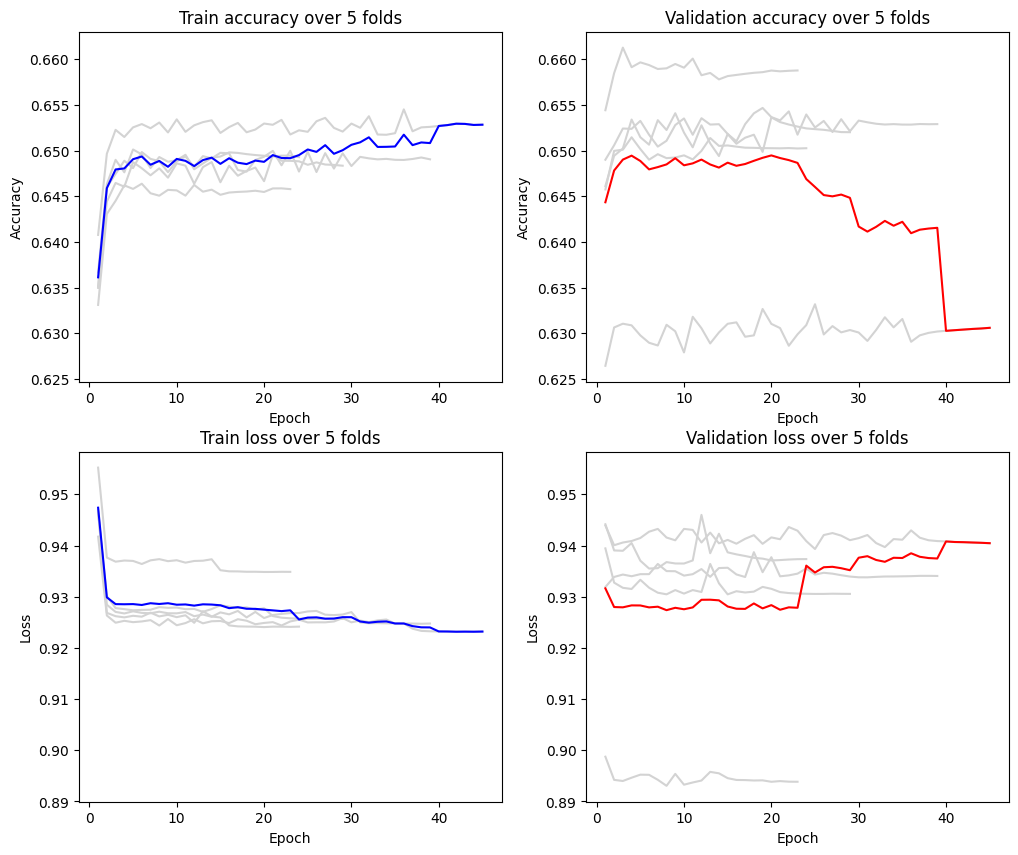

In [ ]:
epoch_num = 300
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)  # Set the seed here

# Create dataset and data loaders
dataset = VesselFlowData(data_X, data_Y)

# Define training and testing accuracy and loss collections
train_acc_set, valid_acc_set, train_loss_set, valid_loss_set, nrmse_set, corr_set, jsd_set = ([] for i in range(7))

# Perform 5-fold cross-validation on the training data
for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
    # Ramdomly sample indexes for training and testing
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(dataset, sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sampler)

    # Create a new model instance and reset weights
    model = ShallowGravity(dim_input=10).to(device)
    model.apply(reset_weights)

    # Use Adam optimizer with learning rate 0.01 and weight decay 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    print(f'Start training and testing on fold {fold+1} ... \n')

    # Train and test the model on the current fold
    # train_acc, test_acc, valid_acc, train_loss, test_loss, valid_loss, test_nrmse, test_corr, test_jsd = execute(epoch_num, trainloader, testloader, model, optimizer)
    train_acc, valid_acc, train_loss, valid_loss, valid_nrmse, valid_corr, valid_jsd = execute(epoch_num, trainloader, validloader, model, optimizer)

    train_acc_set.append(train_acc)
    valid_acc_set.append(valid_acc)
    train_loss_set.append(train_loss)
    valid_loss_set.append(valid_loss)
    nrmse_set.append(valid_nrmse)
    corr_set.append(valid_corr)
    jsd_set.append(valid_jsd)

# Plot accuracy and loss
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
plot_accuracy_and_loss(axs[0], axs[1], axs[2], axs[3], train_acc_set, valid_acc_set, train_loss_set, valid_loss_set, "ACCURACY_LOSS_SG.png")
plt.show()

In [ ]:
torch.save(model.state_dict(), PATH+'Model_ShallowGravity.pth')

**Accuracy report of Shallow Gravity:**

In [ ]:
train_acc_fold_max = [np.nanmax(lst) for lst in train_acc_set if lst]
valid_acc_fold_max = [np.nanmax(lst) for lst in valid_acc_set if lst]
nrmse_fold_min = [np.nanmin(lst) for lst in nrmse_set if lst]
corr_fold_max = [np.nanmax(lst) for lst in corr_set if lst]
jsd_fold_min = [np.nanmin(lst) for lst in jsd_set if lst]

print("Shallow Gravity: \n")
print(f'Training minimum accuracy:   {np.min(train_acc_fold_max)}, maximum accruacy: {np.max(train_acc_fold_max)}, mean accuracy: {np.mean(train_acc_fold_max)}, std = {np.std(train_acc_fold_max)}')
print(f'Validation minimum accuracy: {np.min(valid_acc_fold_max)}, maximum accruacy: {np.max(valid_acc_fold_max)}, mean accuracy: {np.mean(valid_acc_fold_max)}, std = {np.std(valid_acc_fold_max)} \n')
print("Other metrics: \n")
print(f'NRMSE (min):   {np.min(nrmse_fold_min)},  NRMSE (max): {np.max(nrmse_fold_min)},  NRMSE (mean): {np.mean(nrmse_fold_min)}, std = {np.std(nrmse_fold_min)}')
print(f'Pearson (min): {np.min(corr_fold_max)}, Pearson (max): {np.max(corr_fold_max)}, Pearson (mean): {np.mean(corr_fold_max)},  std = {np.std(corr_fold_max)}')
print(f'JSD (min):     {np.min(jsd_fold_min)},      JSD (max): {np.max(jsd_fold_min)},      JSD (mean): {np.mean(jsd_fold_min)},   std = {np.std(jsd_fold_min)}')


Shallow Gravity: 

Training minimum accuracy:   0.646370758750702, maximum accruacy: 0.6545095436251351, mean accuracy: 0.6500973667035597, std = 0.0025966976387902254
Validation minimum accuracy: 0.6331752763186768, maximum accruacy: 0.6612697538442014, mean accuracy: 0.6509306667964131, std = 0.009448297153189284 

Other metrics: 

NRMSE (min):   0.2656920254230499,  NRMSE (max): 0.278444766998291,  NRMSE (mean): 0.27146413922309875, std = 0.004140044562518597
Pearson (min): 0.6767819744251042, Pearson (max): 0.7098048812488732, Pearson (mean): 0.6927614597548433,  std = 0.012056385015937044
JSD (min):     0.3569312976184054,      JSD (max): 0.3759954670698775,      JSD (mean): 0.3645692146435173,   std = 0.0064273078889413165


### Traditional deep gravity

In [ ]:
# Deep Gravity model class (inherits from ShallowGravity)
class DeepGravity(ShallowGravity):
    def __init__(self, dim_input, dim_hidden, dropout_p):
        super().__init__(dim_input)
        p = dropout_p

        self.linear1 = torch.nn.Linear(dim_input, dim_hidden)  # First linear layer
        self.relu1 = torch.nn.LeakyReLU()  # First activation function (LeakyReLU)
        self.dropout1 = torch.nn.Dropout(p)  # First dropout layer

        self.linear2 = torch.nn.Linear(dim_hidden, dim_hidden // 2)  # Second linear layer
        self.relu2 = torch.nn.LeakyReLU()  # Second activation function (LeakyReLU)
        self.dropout2 = torch.nn.Dropout(p)  # Second dropout layer

        self.linear_out = torch.nn.Linear(dim_hidden // 2, 1)  # Output linear layer

    # Forward pass for DeepGravity model
    def forward(self, x):
        x = self.dropout1(self.relu1(self.linear1(x)))  # Pass input through first linear, activation, and dropout layers
        x = self.dropout2(self.relu2(self.linear2(x)))  # Pass input through second linear, activation, and dropout layers
        return self.linear_out(x)  # Pass input through output linear layer

Reset trainable parameters of layer = Linear(in_features=10, out_features=6, bias=True)
Reset trainable parameters of layer = Linear(in_features=6, out_features=3, bias=True)
Reset trainable parameters of layer = Linear(in_features=3, out_features=1, bias=True)
Start training and testing on fold 1 ... 

Epoch 1
Running loss:  0.9751343369218596 ---------- training accuracy: 0.6268227628688355
Validate loss: 0.9677643611033757 ---------- validate accuracy: 0.6290949773025288 

Epoch 2
Running loss:  0.9598947870578777 ---------- training accuracy: 0.6408704792592969
Validate loss: 0.9263227054973443 ---------- validate accuracy: 0.6527353899758068 

Epoch 3
Running loss:  0.9364968447904033 ---------- training accuracy: 0.6602874638473017
Validate loss: 0.9421770556271076 ---------- validate accuracy: 0.6749542635707679 

Epoch 4
Running loss:  0.9346533073874218 ---------- training accuracy: 0.6634784654240421
Validate loss: 0.918792587419351 ---------- validate accuracy: 0.66249598527

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.


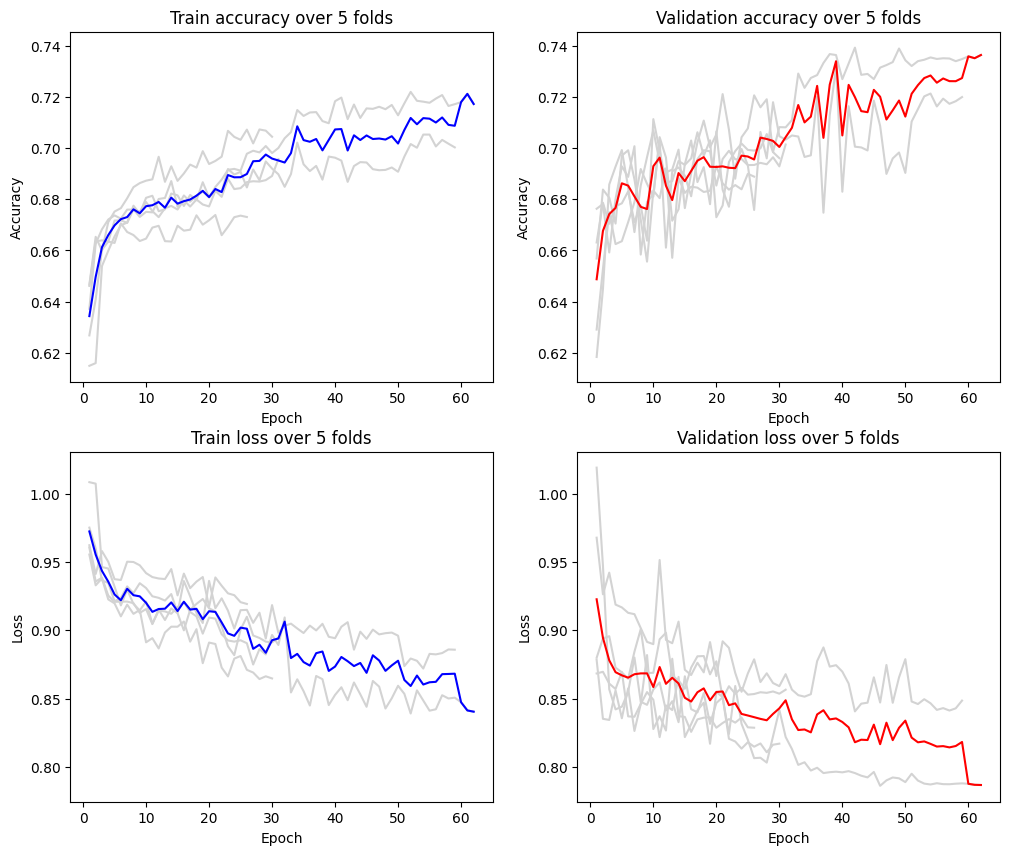

In [ ]:
epoch_num = 300
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create dataset and data loaders
dataset = VesselFlowData(data_X, data_Y)

# Define training and testing accuracy and loss collections
train_acc_set, valid_acc_set, train_loss_set, valid_loss_set, nrmse_set, corr_set, jsd_set = ([] for i in range(7))

# Perform 5-fold cross-validation on the training data
for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
    # Ramdomly sample indexes for training and testing
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(dataset, sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sampler)

    # Create a new model instance and reset weights
    model = DeepGravity(dim_input=10, dim_hidden=6, dropout_p=.1).to(device)
    model.apply(reset_weights)

    # Use Adam optimizer with learning rate 0.01 and weight decay 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    print(f'Start training and testing on fold {fold+1} ... \n')

    # Train and test the model on the current fold
    # train_acc, test_acc, valid_acc, train_loss, test_loss, valid_loss, test_nrmse, test_corr, test_jsd = execute(epoch_num, trainloader, testloader, model, optimizer)
    train_acc, valid_acc, train_loss, valid_loss, valid_nrmse, valid_corr, valid_jsd = execute(epoch_num, trainloader, validloader, model, optimizer)

    train_acc_set.append(train_acc)
    valid_acc_set.append(valid_acc)
    train_loss_set.append(train_loss)
    valid_loss_set.append(valid_loss)
    nrmse_set.append(valid_nrmse)
    corr_set.append(valid_corr)
    jsd_set.append(valid_jsd)

# Plot accuracy and loss
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
plot_accuracy_and_loss(axs[0], axs[1], axs[2], axs[3], train_acc_set, valid_acc_set, train_loss_set, valid_loss_set, "ACCURACY_LOSS_SG.png")
plt.show()

In [ ]:
torch.save(model.state_dict(), PATH+'Model_TraditionalDeepGravity.pth')

**Accuracy report of Traditional Deep Gravity:**

In [ ]:
train_acc_fold_max = [np.nanmax(lst) for lst in train_acc_set if lst]
valid_acc_fold_max = [np.nanmax(lst) for lst in valid_acc_set if lst]
nrmse_fold_min = [np.nanmin(lst) for lst in nrmse_set if lst]
corr_fold_max = [np.nanmax(lst) for lst in corr_set if lst]
jsd_fold_min = [np.nanmin(lst) for lst in jsd_set if lst]

print("Traditional Deep Gravity: \n")
print(f'Training minimum accuracy:   {np.min(train_acc_fold_max)}, maximum accruacy: {np.max(train_acc_fold_max)}, mean accuracy: {np.mean(train_acc_fold_max)}, std = {np.std(train_acc_fold_max)}')
print(f'Validation minimum accuracy: {np.min(valid_acc_fold_max)}, maximum accruacy: {np.max(valid_acc_fold_max)}, mean accuracy: {np.mean(valid_acc_fold_max)}, std = {np.std(valid_acc_fold_max)} \n')
print("Other metrics: \n")
print(f'NRMSE (min):   {np.min(nrmse_fold_min)},  NRMSE (max): {np.max(nrmse_fold_min)},  NRMSE (mean): {np.mean(nrmse_fold_min)}, std = {np.std(nrmse_fold_min)}')
print(f'Pearson (min): {np.min(corr_fold_max)}, Pearson (max): {np.max(corr_fold_max)}, Pearson (mean): {np.mean(corr_fold_max)},  std = {np.std(corr_fold_max)}')
print(f'JSD (min):     {np.min(jsd_fold_min)},      JSD (max): {np.max(jsd_fold_min)},      JSD (mean): {np.mean(jsd_fold_min)},   std = {np.std(jsd_fold_min)}')

Traditional Deep Gravity: 

Training minimum accuracy:   0.6738619340551419, maximum accruacy: 0.7219635469824877, mean accuracy: 0.700816786217256, std = 0.0158855751720273
Validation minimum accuracy: 0.6991420171078481, maximum accruacy: 0.7392518748766632, mean accuracy: 0.7168439855782579, std = 0.015839969062476145 

Other metrics: 

NRMSE (min):   0.22306033968925476,  NRMSE (max): 0.2563805878162384,  NRMSE (mean): 0.24186281859874725, std = 0.011328469961881638
Pearson (min): 0.7399361467326774, Pearson (max): 0.8022139794908154, Pearson (mean): 0.7656538879780901,  std = 0.022732619519981345
JSD (min):     0.3032859699288812,      JSD (max): 0.335072201413862,      JSD (mean): 0.3208985100934864,   std = 0.0106672505649752


### Transformer Deep Gravity

The TransformerGravity model consists of an input embedding layer that maps input features (e.g., port populations, distances between ports) to a higher-dimensional space compatible with the Transformer architecture. Then, a multi-layer Transformer Encoder processes these embeddings to capture complex relationships between input features. Finally, an output linear layer maps the processed embeddings to target flow predictions.

The forward pass of the TransformerGravity model involves passing input data through these layers in sequence: input embedding layer, Transformer Encoder, and output linear layer. Before feeding data into the Transformer Encoder, we need to add an additional sequence length dimension to the input tensor as required by the Transformer architecture. After processing by the Transformer Encoder, we remove this dimension before passing the tensor through the output linear layer.

In [ ]:
# Transformer Gravity model class (inherits from ShallowGravity)
class TransformerGravity(ShallowGravity):
    def __init__(self, dim_input, nhead, num_layers, dim_feedforward, dropout_p):
        super().__init__(dim_input)

        self.embedding = torch.nn.Linear(dim_input, dim_feedforward)
        self.transformer_layer = torch.nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout_p)
        self.transformer = torch.nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.linear_out = torch.nn.Linear(dim_feedforward, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add the sequence length dimension (required by Transformer)
        x = self.transformer(x)
        x = x.squeeze(1)  # Remove the sequence length dimension
        return self.linear_out(x)

Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=64, bias=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=64, bias=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = NonDynamically

Mean of empty slice
The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.


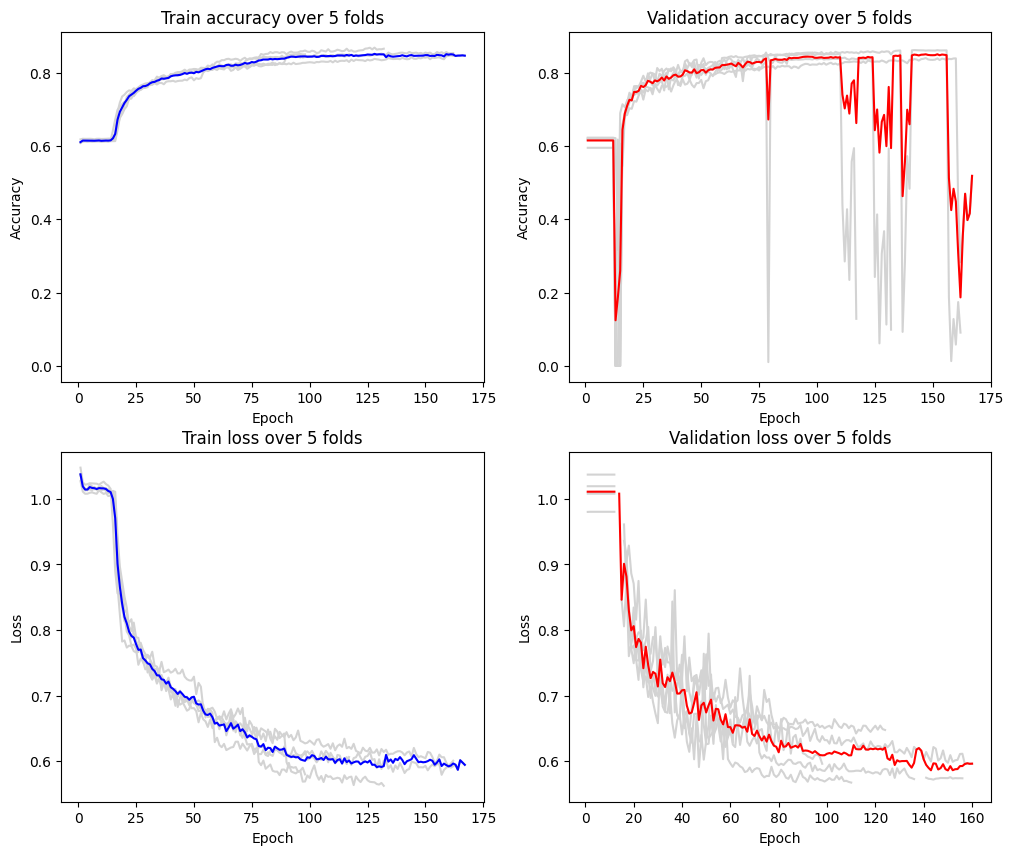

In [ ]:
epoch_num = 300
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create dataset and data loaders
dataset = VesselFlowData(data_X, data_Y)

# Define training and testing accuracy and loss collections
train_acc_set, valid_acc_set, train_loss_set, valid_loss_set, nrmse_set, corr_set, jsd_set = ([] for i in range(7))

# Perform 5-fold cross-validation on the training data
for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
    # Ramdomly sample indexes for training and testing
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(dataset, sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sampler)

    # Create a new model instance and reset weights
    model = TransformerGravity(dim_input=10, nhead=2, num_layers=2, dim_feedforward=64, dropout_p=.1).to(device)
    model.apply(reset_weights)

    # Use Adam optimizer with learning rate 0.01 and weight decay 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    print(f'Start training and testing on fold {fold+1} ... \n')

    # Train and test the model on the current fold
    # train_acc, test_acc, valid_acc, train_loss, test_loss, valid_loss, test_nrmse, test_corr, test_jsd = execute(epoch_num, trainloader, testloader, model, optimizer)
    train_acc, valid_acc, train_loss, valid_loss, valid_nrmse, valid_corr, valid_jsd = execute(epoch_num, trainloader, validloader, model, optimizer)

    train_acc_set.append(train_acc)
    valid_acc_set.append(valid_acc)
    train_loss_set.append(train_loss)
    valid_loss_set.append(valid_loss)
    nrmse_set.append(valid_nrmse)
    corr_set.append(valid_corr)
    jsd_set.append(valid_jsd)

# Plot accuracy and loss
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
plot_accuracy_and_loss(axs[0], axs[1], axs[2], axs[3], train_acc_set, valid_acc_set, train_loss_set, valid_loss_set, "ACCURACY_LOSS_SG.png")
plt.show()

In [ ]:
torch.save(model.state_dict(), PATH+'Model_TransformerDeepGravity.pth')

**Accuracy report of Transformer Deep Gravity:**

In [ ]:
train_acc_fold_max = [np.nanmax(lst) for lst in train_acc_set if lst]
valid_acc_fold_max = [np.nanmax(lst) for lst in valid_acc_set if lst]
nrmse_fold_min = [np.nanmin(lst) for lst in nrmse_set if lst]
corr_fold_max = [np.nanmax(lst) for lst in corr_set if lst]
jsd_fold_min = [np.nanmin(lst) for lst in jsd_set if lst]

print("Transformer Deep Gravity: \n")
print(f'Training minimum accuracy:   {np.min(train_acc_fold_max)}, maximum accruacy: {np.max(train_acc_fold_max)}, mean accuracy: {np.mean(train_acc_fold_max)}, std = {np.std(train_acc_fold_max)}')
print(f'Validation minimum accuracy: {np.min(valid_acc_fold_max)}, maximum accruacy: {np.max(valid_acc_fold_max)}, mean accuracy: {np.mean(valid_acc_fold_max)}, std = {np.std(valid_acc_fold_max)} \n')
print("Other metrics: \n")
print(f'NRMSE (min):   {np.min(nrmse_fold_min)},  NRMSE (max): {np.max(nrmse_fold_min)},  NRMSE (mean): {np.mean(nrmse_fold_min)}, std = {np.std(nrmse_fold_min)}')
print(f'Pearson (min): {np.min(corr_fold_max)}, Pearson (max): {np.max(corr_fold_max)}, Pearson (mean): {np.mean(corr_fold_max)},  std = {np.std(corr_fold_max)}')
print(f'JSD (min):     {np.min(jsd_fold_min)},      JSD (max): {np.max(jsd_fold_min)},      JSD (mean): {np.mean(jsd_fold_min)},   std = {np.std(jsd_fold_min)}')


Transformer Deep Gravity: 

Training minimum accuracy:   0.8478222195319158, maximum accruacy: 0.8686266667858972, mean accuracy: 0.8550030334502484, std = 0.007452861768744534
Validation minimum accuracy: 0.8402926734448485, maximum accruacy: 0.8618938149840077, mean accuracy: 0.8502045769332446, std = 0.008275725665768927 

Other metrics: 

NRMSE (min):   0.07365241646766663,  NRMSE (max): 0.15600159764289856,  NRMSE (mean): 0.12226991653442383, std = 0.028692615262091947
Pearson (min): 0.909218335051986, Pearson (max): 0.9855655345480653, Pearson (mean): 0.9445214213656736,  std = 0.02943701748269314
JSD (min):     0.06971937925271929,      JSD (max): 0.2149789558136296,      JSD (mean): 0.15722697474694328,   std = 0.05247223929871594


### Test model's performance with 2019 flow data

In [ ]:
# Create dataset and data loaders
dataset = VesselFlowData(test_X, test_Y)
testloader = torch.utils.data.DataLoader(dataset)

# Load model and evaluation
model = ShallowGravity(dim_input=10).to(device)
model.load_state_dict(torch.load(PATH+'Model_ShallowGravity.pth'))
test_loss, test_acc, test_nrmse, test_corr, test_jsd = validate(model=model, valid_loader=testloader)
print("Shallow Gravity Test Result:")
print(f"Accuracy: {test_acc} --- Loss: {test_loss} --- NRMSE: {test_nrmse} --- Pearson Corr.: {test_corr} --- JSD: {test_jsd}")

model = DeepGravity(dim_input=10, dim_hidden=6, dropout_p=.1).to(device)
model.load_state_dict(torch.load(PATH+'Model_TraditionalDeepGravity.pth'))
test_loss, test_acc, test_nrmse, test_corr, test_jsd = validate(model=model, valid_loader=testloader)
print("Deep Gravity Test Result:")
print(f"Accuracy: {test_acc} --- Loss: {test_loss} --- NRMSE: {test_nrmse} --- Pearson Corr.: {test_corr} --- JSD: {test_jsd}")

model = TransformerGravity(dim_input=10, nhead=2, num_layers=2, dim_feedforward=64, dropout_p=.1).to(device)
model.load_state_dict(torch.load(PATH+'Model_TransformerDeepGravity.pth'))
test_loss, test_acc, test_nrmse, test_corr, test_jsd = validate(model=model, valid_loader=testloader)
print("Transformer Gravity Test Result:")
print(f"Accuracy: {test_acc} --- Loss: {test_loss} --- NRMSE: {test_nrmse} --- Pearson Corr.: {test_corr} --- JSD: {test_jsd}")

Shallow Gravity Test Result:
Accuracy: 0.686676022799052 --- Loss: 0.835692135852179 --- NRMSE: 0.2825649380683899 --- Pearson Corr.: 0.6992519566598788 --- JSD: 0.3420423443677907
Deep Gravity Test Result:
Accuracy: 0.7408432123449066 --- Loss: 0.8052201498753072 --- NRMSE: 0.2674235999584198 --- Pearson Corr.: 0.7446530658932977 --- JSD: 0.3110495044506855
Transformer Gravity Test Result:
Accuracy: 0.8230988864920513 --- Loss: 0.6400624943296044 --- NRMSE: 0.2146076261997223 --- Pearson Corr.: 0.8452532806441603 --- JSD: 0.24717141144885854


# Ballast water risk assessment (BWRA)

Risk assessment of NIS introduction via ballast water by calculating environmental distances based on the predicted flows.

## Load ports' environmental data

Port identification numbers in the data of ports with salinity&temperature is different from the port ID in `df_port` loaded from World Port Index (WPI), and the port names also cannot fully matched.
Therefore, we match the WPI port data with the nearest port / grid point from the environmental dataset by computing the shortest haversine distances.
The port data with matched environmental info are loaded:

In [ ]:
df_port_env = pd.read_csv(PATH+'data/world_port_index/UpdatedPub150_MergedENV.csv')

## Environmental features processing

In [ ]:
# Feature scaling
# Selecting the columns to be scaled
columns_to_scale = ['MinTemp', 'MaxTemp', 'AnnualTemp', 'Salinity']
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the selected columns
df_port_env[columns_to_scale] = scaler.fit_transform(df_port_env[columns_to_scale])

# Regional features median values
region_env_feature = df_port_env.groupby('sub-region').agg(
        region_MinTemp=('MinTemp', 'median'),
        region_MaxTemp=('MaxTemp', 'median'),
        region_AnnualTemp=('AnnualTemp', 'median'),
        region_Salinity=('Salinity', 'median')
    ).reset_index()

## Shipping flows by the trained model

In [ ]:
# Create dataset and data loaders
dataset = VesselFlowData(test_X, test_Y)
testloader = torch.utils.data.DataLoader(dataset)

# Load existing parameters of Transformer Gravity model
model = TransformerGravity(dim_input=10, nhead=2, num_layers=2, dim_feedforward=64, dropout_p=.1).to(device)
model.load_state_dict(torch.load(PATH+'Model_TransformerDeepGravity.pth'))

model_dg = DeepGravity(dim_input=10, dim_hidden=6, dropout_p=.1).to(device)
model_dg.load_state_dict(torch.load(PATH+'Model_TraditionalDeepGravity.pth'))

<All keys matched successfully>

In [ ]:
# Validation function with detailed comments on inner workings
def get_model_prediction(model, data_loader):
    model.eval()
    y_pred_all = []

    with torch.no_grad():
        for batch_idx, (data_x, data_y) in enumerate(data_loader):
            data_x = data_x.to(device)
            data_y = data_y.to(device)

            for data, target in zip(data_x, data_y):
                y_pred = model.get_pred(data, target).tolist()
                y_pred_all.extend(y_pred)

        y_pred_all = np.asarray(y_pred_all, dtype=np.float32)

        return y_pred_all

In [ ]:
# Predicted flow size calculated from shipping probablity and outflow
test_pred = get_model_prediction(model, testloader)
df_flow19['pred_flow_ratio'] = test_pred
df_flow19['pred_flow_size'] = df_flow19['pred_flow_ratio'] * df_flow19['outflow']

test_pred_dg = get_model_prediction(model_dg, testloader)
df_flow19['pred_flow_ratio_dg'] = test_pred_dg
df_flow19['pred_flow_size_dg'] = df_flow19['pred_flow_ratio_dg'] * df_flow19['outflow']

## Environmental distance calculation

In [ ]:
# Incorporate environmental features
env_feature = ['World Port Index Number', 'MinTemp', 'MaxTemp', 'AnnualTemp', 'Salinity']
df_flow19 = df_flow19.merge(df_port_env[env_feature], left_on='SourcePort', right_on='World Port Index Number', how='left').drop('World Port Index Number', axis=1)
df_flow19 = df_flow19.merge(region_env_feature, left_on='TargetRegion', right_on='sub-region', how='left').drop('sub-region', axis=1)

In [ ]:
def calculate_environment_distance(df, columns_vector1, columns_vector2):
    """
    Calculates the euclidean distance between two sets of environmental vectors in the DataFrame
    :param df: DataFrame containing environmental data
    :param columns_vector1: List of column names for the first environmental vector
    :param columns_vector2: List of column names for the second environmental vector
    :return: Series with distances for each row
    """
    # Calculating differences for each corresponding element in the vectors
    differences = df[columns_vector1].values - df[columns_vector2].values

    # Calculating the Euclidean distance
    distances = np.sqrt(np.sum(np.square(differences), axis=1))

    return np.round(distances, 3)

# Columns representing the two environmental vectors
columns_vector1 = ['MinTemp', 'MaxTemp', 'AnnualTemp', 'Salinity']
columns_vector2 = ['region_MinTemp', 'region_MaxTemp', 'region_AnnualTemp', 'region_Salinity']

# Calculating the distance between the two vectors
df_flow19['Env_Distance'] = calculate_environment_distance(df_flow19, columns_vector1, columns_vector2)

In [ ]:
# Repeating the environmental distance values based on the flow size and creating a Series
df_flow19['flow_size'] = df_flow19['flow_size'].astype(int)
repeated_env_distance_true = pd.Series(np.repeat(df_flow19['Env_Distance'].values, df_flow19['flow_size'].values))

df_flow19['pred_flow_size'] = df_flow19['pred_flow_size'].round().astype(int)
repeated_env_distance_pred = pd.Series(np.repeat(df_flow19['Env_Distance'].values, df_flow19['pred_flow_size'].values))

df_flow19['pred_flow_size_dg'] = df_flow19['pred_flow_size_dg'].round().astype(int)
repeated_env_distance_pred_dg = pd.Series(np.repeat(df_flow19['Env_Distance'].values, df_flow19['pred_flow_size_dg'].values))


In [ ]:
print(len(repeated_env_distance_true), len(repeated_env_distance_pred), len(repeated_env_distance_pred_dg))

1265988 1265991 1266043


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Truncate the longer series to match the length of the shorter one
repeated_env_distance_pred = repeated_env_distance_pred[:len(repeated_env_distance_true)]
repeated_env_distance_pred_dg = repeated_env_distance_pred_dg[:len(repeated_env_distance_true)]

# Calculate Pearson and Spearman correlations
pearson_corr, _ = pearsonr(repeated_env_distance_true, repeated_env_distance_pred)
spearman_corr, _ = spearmanr(repeated_env_distance_true, repeated_env_distance_pred)

# Calculate R2 and MAE
r2 = r2_score(repeated_env_distance_true, repeated_env_distance_pred)
mae = mean_absolute_error(repeated_env_distance_true, repeated_env_distance_pred)

# Calculate MAPE
mape = mean_absolute_percentage_error(repeated_env_distance_true, repeated_env_distance_pred)

# Calculate NRMSE
nrmse_ = nrmse(repeated_env_distance_true, repeated_env_distance_pred)

# Print the results
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Normalized Root Mean Square Error: {nrmse_}")

Pearson Correlation: 0.866372120699876
Spearman Correlation: 0.852496053427384
R2 Score: 0.7344695581588319
Mean Absolute Error: 0.25303516621010624
Mean Absolute Percentage Error: 0.4852115659600046
Normalized Root Mean Square Error: 0.12698201817368654


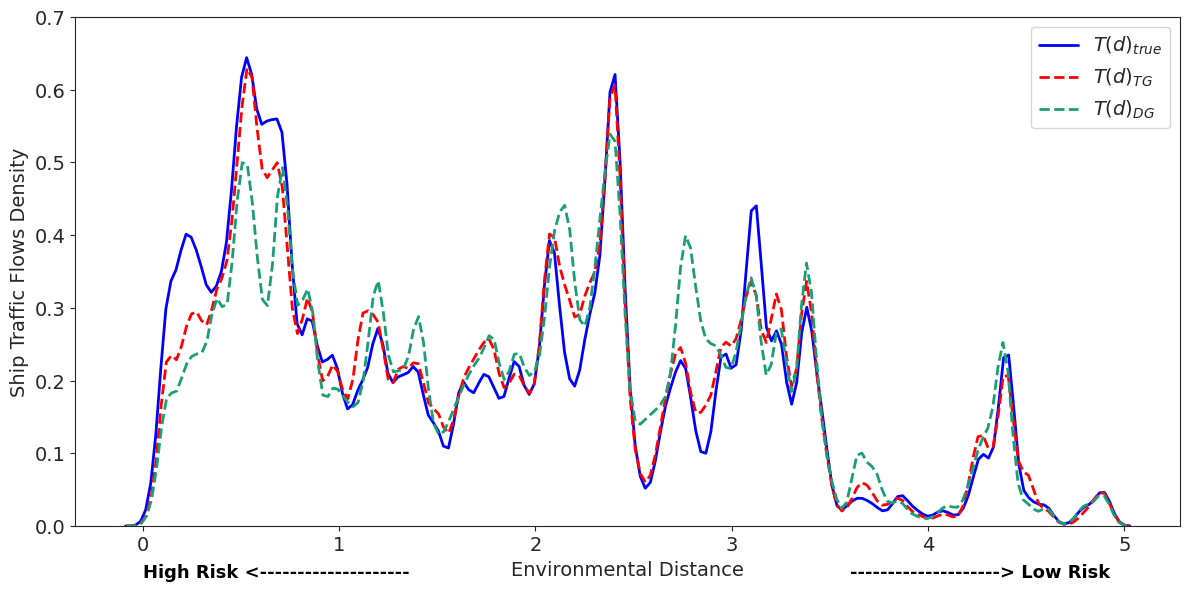

In [ ]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

# Plotting the distribution (Density Plot)
plt.figure(figsize=(12, 6))
sns.set_style(style="ticks")
sns.kdeplot(repeated_env_distance_true, bw_adjust=0.5, label=r'$T(d)_{true}$', color='blue', linewidth=2)
sns.kdeplot(repeated_env_distance_pred, bw_adjust=0.5, label=r'$T(d)_{TG}$', color='red', linewidth=2, linestyle='dashed')
sns.kdeplot(repeated_env_distance_pred_dg, bw_adjust=0.5, label=r'$T(d)_{DG}$', color='#1b9e77', linewidth=2, linestyle='dashed')

# plt.title('Density Plot of True and Predicted Environmental Distances based on 2019 Shipping Network')
plt.ylim(0, 0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Environmental Distance', fontsize=14)
plt.ylabel('Ship Traffic Flows Density', fontsize=14)
plt.legend(prop={'size': 14})
plt.text(0, -0.07, "High Risk <--------------------", fontsize=13, color="black", weight='bold')
plt.text(3.60, -0.07, "--------------------> Low Risk", fontsize=13, color="black", weight='bold')
plt.tight_layout()
plt.savefig(PATH + '/images/environmental_distances.png', format='png', dpi=600)
plt.show()

# Figures and tables

## Graph metrics of the most centered/influential ports

In [16]:
df_flow_all = util.visit_to_flow(df_visit)
flow_all, bc_dict_all, cc_dict_all, pr_dict_all = graph_pipeline(df_flow_all, df_port)

Preparing Edges: 100%|██████████| 5308416/5308416 [00:07<00:00, 710532.88it/s]


In [17]:
G = data2nx_graph(df_flow_all, df_port)

# Find weakly connected components
weakly_connected = nx.weakly_connected_components(G)
for component in weakly_connected:
    print("Weakly connected component:", component)

# Find strongly connected components
strongly_connected = nx.strongly_connected_components(G)
for component in strongly_connected:
    print("Strongly connected component:", component)

bc_dict_all_df = pd.DataFrame.from_dict(bc_dict_all, orient='index').rename(columns={0: "betweenness_centrality"})
cc_dict_all_df = pd.DataFrame.from_dict(cc_dict_all, orient='index').rename(columns={0: "closeness_centrality"})
pr_dict_all_df = pd.DataFrame.from_dict(pr_dict_all, orient='index').rename(columns={0: "page_rank"})

df_graph_metric = pd.concat([bc_dict_all_df, cc_dict_all_df, pr_dict_all_df], axis=1)
df_graph_metric = df_graph_metric.merge(df_port[['World Port Index Number','Main Port Name','World Water Body','Country Name','sub-region']], left_index=True, right_on='World Port Index Number', how='left').drop('World Port Index Number', axis=1)

df_graph_metric.sort_values(by='closeness_centrality', ascending=False).head(20)

# In the "df_graph_metric" dataframe, calculate mean, median, standard deviation of the three metrics grouping by 'sub-region'

df_graph_metric.groupby('sub-region').agg(['mean', 'median', 'max'])


Weakly connected component: {8200, 49160, 32780, 8210, 49170, 40980, 49180, 8225, 8227, 8230, 49200, 41010, 32820, 8245, 8250, 57410, 57411, 8260, 70, 57415, 57420, 57425, 32850, 49240, 8280, 57433, 57434, 57436, 57437, 57439, 57440, 49250, 100, 57446, 57450, 57458, 24690, 8318, 16510, 8325, 16520, 49290, 8330, 57485, 49300, 8340, 8350, 32930, 49320, 170, 8370, 32955, 190, 8390, 16590, 32980, 49370, 8410, 32990, 57570, 57572, 57580, 8430, 16630, 8440, 250, 33020, 49410, 260, 41220, 33030, 24840, 57610, 16650, 8470, 49430, 280, 16670, 8480, 57640, 49450, 8490, 57650, 8500, 310, 57660, 16700, 49470, 8510, 320, 33090, 16710, 49480, 41290, 57680, 16720, 8530, 8540, 16740, 57700, 8550, 41320, 57710, 8560, 33140, 24950, 8570, 49535, 24960, 8580, 8590, 400, 49555, 8595, 57750, 8600, 49560, 57760, 16800, 8610, 16803, 420, 33190, 57768, 57770, 16810, 49580, 57775, 57777, 16820, 8630, 49590, 8640, 41410, 41420, 16850, 57810, 8660, 49620, 8665, 57817, 57818, 57820, 57819, 8670, 480, 33250, 25060,

['Main Port Name', 'World Water Body', 'Country Name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


betweenness_centrality                      \
                                                  mean    median       max   
sub-region                                                                   
Antarctica                                    0.000037  0.000023  0.000089   
Australia and New Zealand                     0.000954  0.000396  0.004723   
Eastern Asia                                  0.000642  0.000202  0.007276   
Eastern Europe                                0.000772  0.000178  0.009221   
Latin America and the Caribbean               0.000855  0.000252  0.018482   
Melanesia                                     0.000505  0.000118  0.002419   
Micronesia                                    0.000502  0.000207  0.002302   
Northern Africa                               0.001845  0.000398  0.017780   
Northern America                              0.001078  0.000219  0.015515   
Northern Europe                               0.000555  0.000135  0.005397   
Polynesia                                     0.000292  0.000094  0.001374   
South-eastern Asia                            0.000836  0.000089  0.021085   
Southern Asia                                 0.001182  0.000507  0.007750   
Southern Europe                               0.001085  0.000184  0.020099   
Sub-Saharan Africa                            0.000882  0.000179  0.011241   
Western Asia                                  0.001000  0.000357  0.006180   
Western Europe                                0.000539  0.000105  0.005588   

                                closeness_centrality                      \
                                                mean    median       max   
sub-region                                                                 
Antarctica                                  0.335781  0.337768  0.361357   
Australia and New Zealand                   0.394248  0.403712  0.486291   
Eastern Asia                                0.363381  0.377896  0.501871   
Eastern Europe                              0.374148  0.375263  0.485259   
Latin America and the Caribbean             0.394940  0.397054  0.538631   
Melanesia                                   0.359197  0.373636  0.424388   
Micronesia                                  0.354663  0.369779  0.412300   
Northern Africa                             0.415370  0.421948  0.538885   
Northern America                            0.340370  0.338668  0.511639   
Northern Europe                             0.357452  0.360844  0.463242   
Polynesia                                   0.344377  0.349165  0.417189   
South-eastern Asia                          0.373005  0.369292  0.562338   
Southern Asia                               0.399408  0.395406  0.485259   
Southern Europe                             0.389977  0.384116  0.552556   
Sub-Saharan Africa                          0.397771  0.396504  0.515910   
Western Asia                                0.404948  0.407343  0.490358   
Western Europe                              0.335357  0.346540  0.469905   

                                page_rank                      
                                     mean    median       max  
sub-region                                                     
Antarctica                       0.000164  0.000102  0.000339  
Australia and New Zealand        0.000415  0.000264  0.001692  
Eastern Asia                     0.000440  0.000188  0.007685  
Eastern Europe                   0.000285  0.000165  0.001567  
Latin America and the Caribbean  0.000487  0.000274  0.006718  
Melanesia                        0.000345  0.000224  0.001267  
Micronesia                       0.000254  0.000139  0.000650  
Northern Africa                  0.000646  0.000301  0.011035  
Northern America                 0.000485  0.000205  0.006226  
Northern Europe                  0.000335  0.000193  0.002884  
Polynesia                        0.000365  0.000377  0.000858  
South-eastern Asia               0.000428  0.000176  0

## Global shipping connections (2017-2019)

In [ ]:
# prompt: drop all the rows having "0.1" value in the column "NumberOfTrips" in the dataframe "flow_all"

flow_all = flow_all.loc[flow_all['NumberOfTrips'] != 0.1]
flow_all = flow_all.merge(df_port[['World Port Index Number','Latitude','Longitude']], left_on='SourcePort', right_on='World Port Index Number').drop(columns='World Port Index Number')

In [ ]:
flux_port = df_visit.groupby(['port', 'latitude', 'longitude']).size().reset_index().rename({0: 'NumberOfStays'}, axis=1)


In [ ]:
# Convert DataFrame to dictionary
ports = {}
for index, row in flux_port.iterrows():
    port_id = row['port']
    coords = (row['longitude'], row['latitude'])
    flux = row['NumberOfStays']
    ports[port_id] = {'coords': coords, 'flux': flux}


# Convert DataFrame to list of dictionaries
connections = []
for index, row in flow_all.iterrows():
    source_port = row['SourcePort']
    target_port = row['TargetPort']
    weight = row['NumberOfTrips']
    connections.append({
        'ports': (source_port, target_port),
        'weight': weight
    })

Processed 0.6969466766097726% connections
Processed 1.3938933532195452% connections
Processed 2.0908400298293177% connections
Processed 2.7877867064390904% connections
Processed 3.484733383048863% connections
Processed 4.181680059658635% connections
Processed 4.878626736268408% connections
Processed 5.575573412878181% connections
Processed 6.272520089487953% connections
Processed 6.969466766097726% connections
Processed 7.666413442707499% connections
Processed 8.36336011931727% connections
Processed 9.060306795927044% connections
Processed 9.757253472536815% connections
Processed 10.454200149146589% connections
Processed 11.151146825756362% connections
Processed 11.848093502366133% connections
Processed 12.545040178975906% connections
Processed 13.24198685558568% connections
Processed 13.938933532195453% connections
Processed 14.635880208805224% connections
Processed 15.332826885414997% connections
Processed 16.02977356202477% connections
Processed 16.72672023863454% connections
Proces

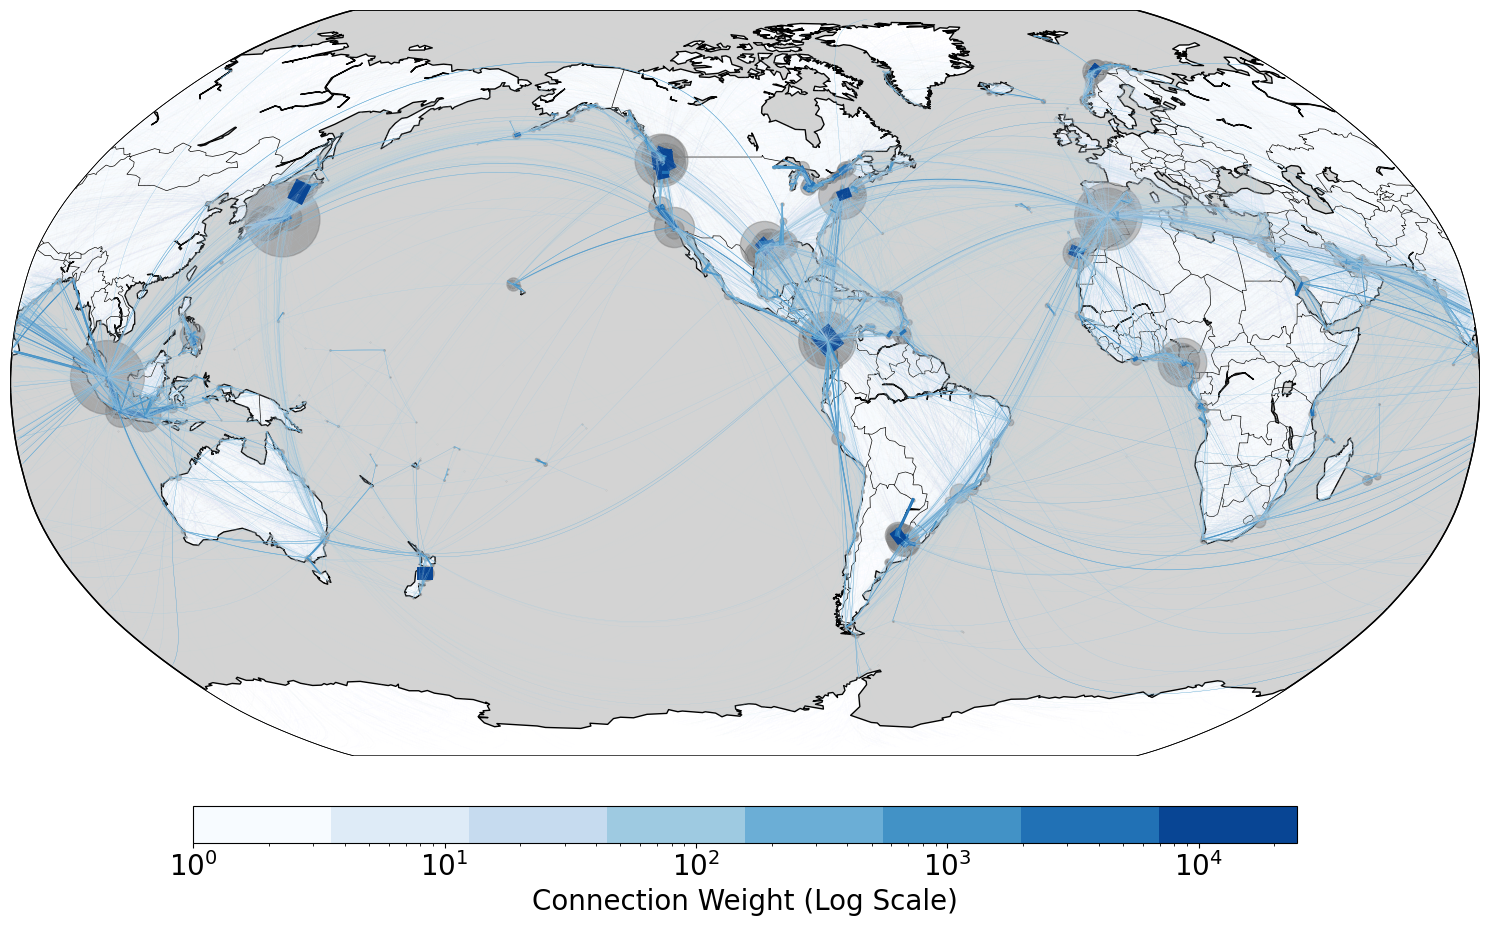

In [ ]:
from geopy.distance import great_circle
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib

matplotlib.rcParams['path.simplify'] = False

# Create a new figure with custom size
fig = plt.figure(figsize=(15, 10))

# Create a gridspec to manage the layout with additional row at the bottom for colorbar
gs = gridspec.GridSpec(2, 1, height_ratios=[19, 1])

# Create the main axis using the first section of the gridspec
ax1 = plt.subplot(gs[0])

# Create a base map
# fig, ax = plt.subplots(figsize=(15, 10))
m = Basemap(
    projection='robin',
    llcrnrlat=-90,
    urcrnrlat=90,
    llcrnrlon=-180,
    urcrnrlon=180,
    resolution='c',
    ax=ax1,
    lon_0=-100  # Center longitude
)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightgrey')
m.fillcontinents(color='white', lake_color='lightgrey')


# Plot ports with marker size based on flux
for port, info in ports.items():
    x, y = m(info["coords"][0], info["coords"][1])
    m.plot(x, y, marker='o', color='grey', markersize=info["flux"] * 0.001, alpha=0.5)

# Obtain the ColorBrewer palette
brewer_palette = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']

# Convert the seaborn palette to a matplotlib colormap
cmap = mcolors.ListedColormap(brewer_palette)

# Use a logarithmic normalization
min_weight = np.log(min([conn['weight'] for conn in connections if conn['weight'] > 0]))
max_weight = np.log(max([conn['weight'] for conn in connections]))
normalize = mcolors.LogNorm(vmin=np.exp(min_weight), vmax=np.exp(max_weight))

# Plot shipping connections with line width based on weight
processed_data = 0
for connection in connections:
    x1, y1 = ports[connection["ports"][0]]["coords"]
    x2, y2 = ports[connection["ports"][1]]["coords"]
    distance = great_circle((y1, x1), (y2, x2)).km
    processed_data += 1
    if processed_data % 1000 == 0:
        print(f"Processed {processed_data*100/143483}% connections")
    # Skip short distances
    if distance < 50:
        continue

    color = cmap(normalize(connection['weight']))
    # m.drawgreatcircle(x1, y1, x2, y2, lw=0.5, color=color)
    m.drawgreatcircle(x1, y1, x2, y2, linewidth=connection['weight']*0.001, color=color)


# Create the colorbar axis using the second section of the gridspec
ax2 = plt.subplot(gs[1])

# Add colorbar with horizontal orientation
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', fraction=0.8, pad=0.1, aspect=30)
cbar.set_label('Connection Weight (Log Scale)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.gca().axis('off')
plt.tight_layout()
plt.savefig(PATH+'/images/port_connection.png', format='png')
plt.show()